Projet réalisé en binome avec Léon DEBEVER et Quentin DOMON dans le cadre d'un projet dirigé par M.TAJINI. Certaines parties de codes ont été faites aussi en collaboration avec Lorenzo COUZINET en particulier lors du lab2.

Tous les lab sont dans ce fichiers, assignment et practice confondu.

### Lab 0

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("jlab-test").getOrCreate()
spark.range(3).show()
spark.stop()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/03 16:30:55 WARN Utils: Your hostname, DESKTOP-LMK6ST6, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/03 16:30:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/03 16:30:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+
| id|
+---+
|  0|
|  1|
|  2|
+---+



In [2]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [3]:
import findspark, pyspark
from pyspark.sql import SparkSession
findspark.init()
spark = SparkSession.builder.appName("de1-check").getOrCreate()
print("Spark:", spark.version)
print("PySpark:", pyspark.__version__)

Spark: 4.1.0
PySpark: 4.1.0


In [4]:
import os

# 1. Créer le dossier 'data' s'il n'existe pas
os.makedirs('data', exist_ok=True)

# 2. Définir le contenu du CSV
csv_content = """id,name,value
1,Alice,10
2,Bob,20
3,Charlie,30
4,David,40
5,Eve,50"""

# 3. Écrire le fichier
with open('data/sample.csv', 'w') as f:
    f.write(csv_content)

print("Fichier data/sample.csv créé avec succès !")

Fichier data/sample.csv créé avec succès !


In [5]:
df = spark.read.option("header","true").csv("data/sample.csv")
df.show(5)
df.explain("formatted")

+---+-------+-----+
| id|   name|value|
+---+-------+-----+
|  1|  Alice|   10|
|  2|    Bob|   20|
|  3|Charlie|   30|
|  4|  David|   40|
|  5|    Eve|   50|
+---+-------+-----+

== Physical Plan ==
Scan csv  (1)


(1) Scan csv 
Output [3]: [id#22, name#23, value#24]
Batched: false
Location: InMemoryFileIndex [file:/home/qdomon/data/sample.csv]
ReadSchema: struct<id:string,name:string,value:string>




In [6]:
import sys, os, subprocess, json, datetime, platform
print("Python:", sys.version)
print("Platform:", platform.platform())
# Java version
try:
    out = subprocess.check_output(["java","-version"], stderr=subprocess.STDOUT).decode()
    print(out.splitlines()[0])
except Exception as e:
    print("java -version failed:", e)


Python: 3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]
Platform: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.39
openjdk version "21.0.6-internal" 2025-01-21


In [7]:
import findspark, pyspark
from pyspark.sql import SparkSession
findspark.init()
print("PySpark:", pyspark.__version__)
spark = SparkSession.builder.appName("de1-lab0").getOrCreate()
print("Spark:", spark.version)

PySpark: 4.1.0
Spark: 4.1.0


26/01/03 16:31:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [8]:
import os, csv, pathlib
pathlib.Path("data").mkdir(exist_ok=True)
rows = [
    {"user_id":1,"product_id":101,"price":9.9,"ts":"2025-09-01T09:00:00"},
    {"user_id":1,"product_id":102,"price":19.0,"ts":"2025-09-01T09:02:00"},
    {"user_id":2,"product_id":101,"price":9.9,"ts":"2025-09-02T10:00:00"},
    {"user_id":3,"product_id":103,"price":5.5,"ts":"2025-09-03T11:30:00"},
]
with open("data/sample_sales.csv","w",newline="") as f:
    w = csv.DictWriter(f, fieldnames=["user_id","product_id","price","ts"])
    w.writeheader(); w.writerows(rows)
print("Wrote data/sample_sales.csv, bytes:", os.path.getsize("data/sample_sales.csv"))

Wrote data/sample_sales.csv, bytes: 154


In [9]:
df = spark.read.option("header","true").option("inferSchema","true").csv("data/sample_sales.csv")
df.printSchema()
df.show()

root
 |-- user_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- ts: timestamp (nullable = true)

+-------+----------+-----+-------------------+
|user_id|product_id|price|                 ts|
+-------+----------+-----+-------------------+
|      1|       101|  9.9|2025-09-01 09:00:00|
|      1|       102| 19.0|2025-09-01 09:02:00|
|      2|       101|  9.9|2025-09-02 10:00:00|
|      3|       103|  5.5|2025-09-03 11:30:00|
+-------+----------+-----+-------------------+



In [10]:
from pyspark.sql import functions as F
agg = df.groupBy("user_id").agg(F.count("*").alias("n"), F.sum("price").alias("total"))
agg.show()
plan = agg._jdf.queryExecution().executedPlan().toString()
print(plan)
print("\n=== explain formatted ===")
agg.explain("formatted")

# Save evidence
import pathlib, datetime
pathlib.Path("proof").mkdir(exist_ok=True)
with open("proof/plan_formatted.txt","w") as f:
    f.write(str(datetime.datetime.now()) + "\n\n")
    f.write(str(plan))
print("Saved proof/plan_formatted.txt")

+-------+---+-----+
|user_id|  n|total|
+-------+---+-----+
|      1|  2| 28.9|
|      3|  1|  5.5|
|      2|  1|  9.9|
+-------+---+-----+

AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[user_id#56], functions=[count(1), sum(price#58)], output=[user_id#56, n#78L, total#79])
   +- Exchange hashpartitioning(user_id#56, 200), ENSURE_REQUIREMENTS, [plan_id=126]
      +- HashAggregate(keys=[user_id#56], functions=[partial_count(1), partial_sum(price#58)], output=[user_id#56, count#91L, sum#92])
         +- FileScan csv [user_id#56,price#58] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/home/qdomon/data/sample_sales.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user_id:int,price:double>


=== explain formatted ===
== Physical Plan ==
AdaptiveSparkPlan (5)
+- HashAggregate (4)
   +- Exchange (3)
      +- HashAggregate (2)
         +- Scan csv  (1)


(1) Scan csv 
Output [2]: [user_id#56, price#58]
Batched: false
Locat

In [11]:
spark.stop()
print("Spark session stopped.")

Spark session stopped.


### lab1-assignment

In [12]:
import findspark, os
os.environ["SPARK_HOME"] = "/path/to/spark-4.0.0-bin-hadoop3"
findspark.init()

In [13]:
DATAPATH = "//wsl.localhost/Ubuntu-24.04/home/qdomona1-brand.csv"

In [14]:
import sys, re
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.sql.functions import col

In [15]:
from IPython.core.magic import register_cell_magic
import time, os, platform
import psutil, resource

def _rss_bytes():
    return psutil.Process(os.getpid()).memory_info().rss

def _ru_maxrss_bytes():
    # ru_maxrss: bytes on macOS; kilobytes on Linux
    ru = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    if platform.system() == "Darwin":
        return int(ru)  # bytes
    else:
        return int(ru) * 1024  # KB -> bytes

@register_cell_magic
def timemem(line, cell):
    """
    Measure wall time and memory around the execution of this cell.
    Usage:
        %%timemem
        <your code>
    """
    ip = get_ipython()
    rss_before = _rss_bytes()
    peak_before = _ru_maxrss_bytes()
    t0 = time.perf_counter()

    # Execute the cell body
    result = ip.run_cell(cell)

    t1 = time.perf_counter()
    rss_after = _rss_bytes()
    peak_after = _ru_maxrss_bytes()

    wall = t1 - t0
    rss_delta_mb = (rss_after - rss_before) / (1024*1024)
    peak_delta_mb = (peak_after - peak_before) / (1024*1024)

    print("======================================")
    print(f"Wall time: {wall:.3f} s")
    print(f"RSS Δ: {rss_delta_mb:+.2f} MB")
    print(f"Peak memory Δ: {peak_delta_mb:+.2f} MB (OS-dependent)")
    print("======================================")

    return result

In [16]:
%%timemem

spark = (
    SparkSession.builder
    .appName("Assignment1")
    .master("local[*]")            # Use all local cores
    .config("spark.ui.showConsoleProgress", "true")
    .getOrCreate()
)

spark

Wall time: 0.154 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f84a9030, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f84a92a0, raw_cell="
spark = (
    SparkSession.builder
    .appName(".." store_history=False silent=False shell_futures=True cell_id=None> result=<pyspark.sql.session.SparkSession object at 0x7f19f8325630>>

In [17]:
%%timemem

# TODO: Write your code below, but do not remove any lines already in this cell.

sc = spark.sparkContext
lines = sc.textFile("a1-brand.csv")

# By the time we get to here, "lines" should refer to an RDD with the brand file loaded.
# Let's count the lines.

lines.count()

7262

Wall time: 1.169 s
RSS Δ: +0.62 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f8325720, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f8326290, raw_cell="
# TODO: Write your code below, but do not remove .." store_history=False silent=False shell_futures=True cell_id=None> result=7262>

In [18]:
%%timemem

# TODO: Write your code below, but do not remove any lines already in this cell.

df = spark.read.option("header", "true").option("escape", "\"").csv("a1-brand.csv")

# By the time we get to here, the file should have already been loaded into a DataFrame.
# Here, we just inspect it.

print("Rows:", df.count())
df.printSchema()
df.select("description").show(5, truncate=80)

Rows: 7261
root
 |-- brand: string (nullable = true)
 |-- description: string (nullable = true)

+--------------------------------------------------------------------------------+
|                                                                     description|
+--------------------------------------------------------------------------------+
|a-case is a brand specializing in protective accessories for electronic devic...|
|A-Derma is a French dermatological skincare brand specializing in products fo...|
| a patented ingredient derived from oat plants cultivated under organic farmi...|
|                                                                       cleansers|
|           A-Derma emphasizes clinical efficacy and hypoallergenic formulations.|
+--------------------------------------------------------------------------------+
only showing top 5 rows
Wall time: 0.556 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f8326ce0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f8327970, raw_cell="
# TODO: Write your code below, but do not remove .." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [19]:
%%timemem

# TODO: Write your code below, but do not remove any lines already in this cell.

from pyspark.sql import functions as F

# 1. Passage en minuscule et remplacement des caractères non-alphabétiques par des espaces
cleaned_df = df.select(F.regexp_replace(F.lower(F.col("description")), "[^a-z]", " ").alias("text"))

# 2. Découpage en mots (split) et transformation de la liste en lignes (explode)
words_df = cleaned_df.select(F.explode(F.split(F.col("text"), "\\s+")).alias("word"))

# 3. Filtrage par longueur et comptage trié
word_counts = words_df.filter(F.length(F.col("word")) >= 2) \
    .groupBy("word") \
    .count() \
    .orderBy(F.col("count").desc())

# By the time we get to here "word_counts" is a DataFrame that already has the word counts sorted in descending order.
# So we just print out the top-10.

top10 = word_counts.limit(10)
top10.show()

[Stage 6:>                                                          (0 + 1) / 1]

+-----+-----+
| word|count|
+-----+-----+
|  and|13094|
|  the| 6895|
|   is| 6419|
|   in| 6351|
|  for| 5530|
|brand| 5196|
|  its| 3304|
|   to| 3155|
|   of| 2692|
|known| 2509|
+-----+-----+

Wall time: 2.647 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f8325e70, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f8326e60, raw_cell="
# TODO: Write your code below, but do not remove .." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [20]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [21]:
%%timemem

# TODO: Write your code below, but do not remove any lines already in this cell.

import numpy
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql import functions as F

# 1. On filtre les lignes où la description est vide pour éviter le crash (NullPointerException)
# On nettoie et on transforme en tableau de mots (tokens)
tokens_df = df.filter(F.col("description").isNotNull()) \
    .select(F.split(F.regexp_replace(F.lower(F.col("description")), "[^a-z]", " "), "\\s+").alias("tokens"))

# 2. Utilisation du StopWordsRemover sur des données propres
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
filtered_df = remover.transform(tokens_df)

# 3. Explosion du tableau, filtrage des mots courts et comptage
word_counts_noStopWords = filtered_df.select(F.explode(F.col("filtered_tokens")).alias("word")) \
    .filter(F.length(F.col("word")) >= 2) \
    .groupBy("word") \
    .count() \
    .orderBy(F.col("count").desc())
# By the time we get to here "word_counts_noStopWords" is a DataFrame that already has the word counts sorted in descending order.
# So we just print out the top-10.

top10_noStopWords = word_counts_noStopWords.limit(10)
top10_noStopWords.show()

[Stage 9:>                                                          (0 + 1) / 1]

+------------+-----+
|        word|count|
+------------+-----+
|       brand| 5196|
|       known| 2509|
|    products| 2459|
|   primarily| 2100|
|      market| 1873|
|       range| 1688|
|  recognized| 1482|
|   including| 1452|
|specializing| 1390|
|       often| 1247|
+------------+-----+

Wall time: 1.932 s
RSS Δ: +4.25 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f9ec1810, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f1a280803a0, raw_cell="
# TODO: Write your code below, but do not remove .." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [22]:
%%timemem

# TODO: Write your code below, but do not remove any lines already in this cell.

# 1. Sauvegarde du Top 10 avec les mots vides (stopwords)
top10.write.mode("overwrite").option("header", "true").csv("top10_words.csv")

# 2. Sauvegarde du Top 10 sans les mots vides
top10_noStopWords.write.mode("overwrite").option("header", "true").csv("top10_noStopWords.csv")

Wall time: 1.350 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f9ec18a0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f9ec1960, raw_cell="
# TODO: Write your code below, but do not remove .." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [23]:
spark.stop()

### lab1-practice

In [24]:
import os, sys, datetime, pathlib
from pyspark.sql import SparkSession, functions as F
print("Python:", sys.version)
spark = SparkSession.builder.appName("de1-lab1").getOrCreate()
print("Spark:", spark.version)


Python: 3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]
Spark: 4.1.0


In [25]:
src_a = "data/lab1_dataset_a.csv"
src_b = "data/lab1_dataset_b.csv"
df_a = spark.read.option("header","true").option("inferSchema","true").csv(src_a)
df_b = spark.read.option("header","true").option("inferSchema","true").csv(src_b)
df = df_a.unionByName(df_b)
df.cache()
print("Rows:", df.count())
df.printSchema()
df.show(5, truncate=False)


Rows: 2700
root
 |-- id: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- value: double (nullable = true)
 |-- text: string (nullable = true)

+---+-----------+-----+----------------------------------------------------------------------------+
|id |category   |value|text                                                                        |
+---+-----------+-----+----------------------------------------------------------------------------+
|0  |toys       |48.47|metrics ui data elt row columnar reduce warehouse shuffle join spark elt    |
|1  |books      |39.9 |metrics row lake aggregate columnar data reduce row columnar filter         |
|2  |grocery    |7.96 |lake join partition scala elt data                                          |
|3  |electronics|5.15 |spark scala elt filter join columnar lake lake plan warehouse columnar spark|
|4  |toys       |44.87|aggregate metrics row row filter lake map metrics columnar spark            |
+---+-----------+-----+----

In [26]:
# RDD pipeline: tokenize 'text' column and count tokens
rdd = df.select("text").rdd.flatMap(lambda row: (row[0] or "").lower().split())
pair = rdd.map(lambda t: (t, 1))
counts = pair.reduceByKey(lambda a,b: a+b)
top_rdd = counts.sortBy(lambda kv: (-kv[1], kv[0])).take(10)
top_rdd


[('lake', 1215),
 ('scala', 1200),
 ('elt', 1199),
 ('metrics', 1190),
 ('row', 1183),
 ('join', 1169),
 ('warehouse', 1168),
 ('shuffle', 1160),
 ('ui', 1145),
 ('aggregate', 1144)]

In [27]:
# Save as CSV (token,count)
pathlib.Path("outputs").mkdir(exist_ok=True)
with open("outputs/top10_rdd.csv","w",encoding="utf-8") as f:
    f.write("token,count\n")
    for t,c in top_rdd:
        f.write(f"{t},{c}\n")
print("Wrote outputs/top10_rdd.csv")


Wrote outputs/top10_rdd.csv


In [28]:
# Trigger an action and record a textual plan for evidence
_ = counts.count()
plan_rdd = df._jdf.queryExecution().executedPlan().toString()
pathlib.Path("proof").mkdir(exist_ok=True)
with open("proof/plan_rdd.txt","w") as f:
    f.write(str(datetime.datetime.now()) + "\n\n")
    f.write(plan_rdd)
print("Saved proof/plan_rdd.txt")


Saved proof/plan_rdd.txt


In [29]:
tokens = F.explode(F.split(F.lower(F.col("text")), "\\s+")).alias("token")
df_tokens = df.select(tokens).where(F.col("token") != "")
agg_df = df_tokens.groupBy("token").agg(F.count("*").alias("count"))
top_df = agg_df.orderBy(F.desc("count"), F.asc("token")).limit(10)
top_df.show(truncate=False)
top_df.coalesce(1).write.mode("overwrite").option("header","true").csv("outputs/top10_df_tmp")
# move single part file to stable path
import glob, shutil
part = glob.glob("outputs/top10_df_tmp/part*")[0]
shutil.copy(part, "outputs/top10_df.csv")
print("Wrote outputs/top10_df.csv")


+---------+-----+
|token    |count|
+---------+-----+
|lake     |1215 |
|scala    |1200 |
|elt      |1199 |
|metrics  |1190 |
|row      |1183 |
|join     |1169 |
|warehouse|1168 |
|shuffle  |1160 |
|ui       |1145 |
|aggregate|1144 |
+---------+-----+

Wrote outputs/top10_df.csv


In [30]:
plan_df = top_df._jdf.queryExecution().executedPlan().toString()
with open("proof/plan_df.txt","w") as f:
    f.write(str(datetime.datetime.now()) + "\n\n")
    f.write(plan_df)
print("Saved proof/plan_df.txt")


Saved proof/plan_df.txt


In [31]:
# Case A: select all columns then aggregate on 'category'
all_cols = df.select("*").groupBy("category").agg(F.sum("value").alias("sum_value"))
all_cols.explain("formatted")
_ = all_cols.count()  # trigger

# Case B: minimal projection then aggregate
proj = df.select("category","value").groupBy("category").agg(F.sum("value").alias("sum_value"))
proj.explain("formatted")
_ = proj.count()  # trigger

print("Open Spark UI at http://localhost:4040 while each job runs and record metrics into lab1_metrics_log.csv")


== Physical Plan ==
AdaptiveSparkPlan (9)
+- HashAggregate (8)
   +- Exchange (7)
      +- HashAggregate (6)
         +- InMemoryTableScan (1)
               +- InMemoryRelation (2)
                     +- Union (5)
                        :- Scan csv  (3)
                        +- Scan csv  (4)


(1) InMemoryTableScan
Output [2]: [category#194, value#195]
Arguments: [category#194, value#195]

(2) InMemoryRelation
Arguments: [id#193, category#194, value#195, text#196], StorageLevel(disk, memory, deserialized, 1 replicas)

(3) Scan csv 
Output [4]: [id#193, category#194, value#195, text#196]
Batched: false
Location: InMemoryFileIndex [file:/home/qdomon/data/lab1_dataset_a.csv]
ReadSchema: struct<id:int,category:string,value:double,text:string>

(4) Scan csv 
Output [4]: [id#214, category#215, value#216, text#217]
Batched: false
Location: InMemoryFileIndex [file:/home/qdomon/data/lab1_dataset_b.csv]
ReadSchema: struct<id:int,category:string,value:double,text:string>

(5) Union

(6) Hash

In [32]:
spark.stop()
print("Spark session stopped.")


Spark session stopped.


### lab2-assignment

In [33]:
SOURCE_A_PATH = 'data/source_a.csv'
SOURCE_B_PATH = 'data/source_b.csv'
OUTPUT_BASE   = 'out/a2_v3_output'

In [34]:
import logging
from typing import Optional, Tuple
from pyspark.sql import DataFrame, SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType



    # Configuration du logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def ingest(spark, path_a: str, path_b: str) -> Tuple[DataFrame, DataFrame]:
    """Load SOURCE_A and SOURCE_B. Apply explicit schemas where possible.
    Return two DataFrames with uniform column naming.
    """
    # Définition de schémas explicites
    schema_a = StructType([
        StructField("id", StringType(), False),
        StructField("raw_timestamp", StringType(), True),
        StructField("value", IntegerType(), True),
        StructField("category", StringType(), True)
    ])
    
    schema_b = StructType([
        StructField("id_ref", StringType(), False),
        StructField("label", StringType(), True),
        StructField("metadata", StringType(), True)
    ])

    # Lecture avec schémas
    df_a = spark.read.schema(schema_a).option("header", "true").csv(path_a)
    df_b = spark.read.schema(schema_b).option("header", "true").csv(path_b)

    # Uniformisation des noms de colonnes (ex: snake_case)
    df_a = df_a.select([F.col(c).alias(c.lower()) for c in df_a.columns])
    df_b = df_b.select([F.col(c).alias(c.lower()) for c in df_b.columns])

    logger.info(f"Ingest - DF_A count: {df_a.count()}")
    logger.info(f"Ingest - DF_B count: {df_b.count()}")
    
    return df_a, df_b
    raise NotImplementedError

def transform(df_a: DataFrame, df_b: DataFrame) -> DataFrame:
    """Clean, deduplicate, and normalize. Add parsed timestamps.
    Drop obvious null records. Prepare keys for join.
    """
    # 1. Nettoyage et Cast des dates
    df_a_clean = df_a.dropna(subset=["id"]) \
                     .withColumn("timestamp", F.to_timestamp("raw_timestamp")) \
                     .drop("raw_timestamp")

    # 2. Déduplication
    df_a_clean = df_a_clean.dropDuplicates(["id", "timestamp"])
    df_b_clean = df_b.dropDuplicates(["id_ref"])

    # 3. Préparation des clés pour la jointure
    df_a_clean = df_a_clean.withColumnRenamed("id", "join_key")
    df_b_clean = df_b_clean.withColumnRenamed("id_ref", "join_key")

    # On retourne ici df_a transformé, prêt à être joint à df_b plus tard
    # Note : Le pattern habituel est de retourner un DF consolidé ou les deux
    logger.info(f"Transform - Cleaned DF_A count: {df_a_clean.count()}")
    
    return df_a_clean, df_b_clean
    raise NotImplementedError

def join_and_aggregate(df: DataFrame, dim: DataFrame) -> DataFrame:
    """Join with dim table. Handle potential skew (hint: salting or AQE).
    Compute business aggregates with window or groupBy.
    """
    # Gestion du Skew par Salting (salage)
    # On ajoute une colonne de sel pour répartir les clés trop fréquentes
    SALT_NUMBER = 10 # À ajuster selon le volume
    
    df_salted = df.withColumn("salt", (F.rand() * SALT_NUMBER).cast("int"))
    
    # Pour la table de dimension, on doit répliquer les lignes pour chaque sel
    dim_salted = dim.withColumn("salt_array", F.array([F.lit(i) for i in range(SALT_NUMBER)]))
    dim_salted = dim_salted.withColumn("salt", F.explode("salt_array")).drop("salt_array")

    # Jointure
    joined_df = df_salted.join(dim_salted, ["join_key", "salt"], "left")

    # Agrégations business
    result_df = joined_df.groupBy("category", "label").agg(
        F.sum("value").alias("total_value"),
        F.count("join_key").alias("occurrence_count"),
        F.max("timestamp").alias("last_update")
    )

    logger.info(f"Join & Aggregate - Result count: {result_df.count()}")
    return result_df
    raise NotImplementedError

def write_out(df: DataFrame, base: str, partitions: list[str]) -> None:
    """Write Parquet, overwrite mode, partitioned by `partitions`.
    Optimize small files if needed (coalesce).
    """
    # Optimisation : Coalesce pour éviter de créer des milliers de petits fichiers
    # si le volume de sortie est modéré, ou repartition si on veut paralléliser.
    output_df = df.coalesce(1) 

    output_df.write \
        .mode("overwrite") \
        .partitionBy(*partitions) \
        .parquet(base)
    
    logger.info(f"Write - Data successfully written to {base}")
    raise NotImplementedError


In [35]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
import logging

SEED = 42
spark.conf.set("spark.sql.shuffle.partitions", "200") # Valeur standard
spark.conf.set("spark.sql.adaptive.enabled", "true")   # AQE pour gérer le skew automatiquement


# Orchestration
## Replace raises with your implementation, then run this driver.
if spark is not None:
    # write some code here
    
    # Configuration pour la reproductibilité
    
    logger = logging.getLogger("DataPipeline")
    
    def ingest(spark: SparkSession, path_a: str, path_b: str) -> Tuple[DataFrame, DataFrame]:
        # Schéma avec colonne pour capturer les erreurs de parsing
        schema_a = StructType([
            StructField("id", StringType(), True),
            StructField("event_date", StringType(), True),
            StructField("value", IntegerType(), True),
            StructField("category", StringType(), True),
            StructField("_corrupt_record", StringType(), True) # Capture les lignes malformées
        ])
    
        def load_with_reporting(path: str, schema: StructType, name: str):
            df = spark.read.format("csv") \
                .option("header", "true") \
                .option("columnNameOfCorruptRecord", "_corrupt_record") \
                .schema(schema) \
                .load(path)
            
            total = df.count()
            malformed = df.filter(F.col("_corrupt_record").isNotNull()).count()
            logger.info(f"Source {name}: {total} rows loaded, {malformed} malformed records.")
            return df.filter(F.col("_corrupt_record").isNull()).drop("_corrupt_record")
    
        return load_with_reporting(path_a, schema_a, "A"), load_with_reporting(path_b, None, "B")
    
    def transform(df_a: DataFrame) -> DataFrame:
        # Standardisation, Cast et Timestamps UTC
        stg = df_a.select(
            F.col("id").alias("user_id"),
            F.to_utc_timestamp(F.col("event_date"), "UTC").alias("ts_utc"),
            F.col("value").cast("double"),
            F.upper(F.col("category")).alias("category")
        ).dropna(subset=["user_id", "ts_utc"]) # Quality: drop vital nulls
        
        # Déduplication sur clé métier + timestamp
        stg = stg.dropDuplicates(["user_id", "ts_utc"])
        
        logger.info(f"Transform: {stg.count()} records after cleaning/dedup.")
        return stg
    
    def join_and_aggregate(df: DataFrame, dim: DataFrame) -> DataFrame:
        """
        Stratégie : Salted Join pour mitiger le skew. 
        On ajoute un 'sel' (0-9) aux clés pour répartir la charge sur les exécuteurs.
        """
        SALT_BUCKETS = 10
        
        # Salage de la table de faits
        df_salted = df.withColumn("salt", (F.rand(SEED) * SALT_BUCKETS).cast("int"))
        
        # Réplication de la table de dimension
        dim_salted = dim.withColumn("salt_array", F.array([F.lit(i) for i in range(SALT_BUCKETS)])) \
                        .withColumn("salt", F.explode("salt_array"))
        
        # Jointure et agrégation journalière
        res = df_salted.join(dim_salted, [df_salted.user_id == dim_salted.id_ref, "salt"], "inner") \
            .groupBy(F.to_date("ts_utc").alias("event_day"), "category") \
            .agg(
                F.sum("value").alias("daily_sum"),
                F.countDistinct("user_id").alias("unique_users")
            )
        
        return res
    
    def run_quality_gates(df: DataFrame, source_count: int):
        # 1. Vérification volume non nul
        count = df.count()
        if count == 0:
            raise ValueError("Gate Failed: DataFrame is empty.")
        
        # 2. Vérification du taux de nullité (seuil 5%)
        null_rate = df.filter(F.col("category").isNull()).count() / count
        if null_rate > 0.05:
            raise ValueError(f"Gate Failed: Null rate too high ({null_rate:.2%}).")
            
        # 3. Couverture référentielle (Exemple simplifié)
        logger.info("Quality Gates passed successfully.")
        
        df_a, df_b = ingest(spark, SOURCE_A_PATH, SOURCE_B_PATH)
        stg = transform(df_a, df_b)
        out = join_and_aggregate(stg, df_b)
        print('Final count:', out.count())
        print('Plan:')
        out.explain(mode='formatted')
    pass


In [36]:
pip install psycopg[binary]

Note: you may need to restart the kernel to use updated packages.


In [37]:
!dropdb --if-exists esiee_full
!createdb esiee_full
!pg_restore   -d esiee_full   --jobs 4 --clean --if-exists   --no-owner --no-acl   retail_schema_20250826.dump

In [38]:
# 1- Run this in your terminal to create a read-only user for the database :
#!sudo -u postgres psql -d esiee_full -c "CREATE ROLE esiee_reader WITH LOGIN PASSWORD 'azerty123'; GRANT CONNECT ON DATABASE esiee_full TO esiee_reader; GRANT USAGE ON SCHEMA retail TO esiee_reader; GRANT SELECT ON ALL TABLES IN SCHEMA retail TO esiee_reader; ALTER DEFAULT PRIVILEGES IN SCHEMA retail GRANT SELECT ON TABLES TO esiee_reader;"

In [39]:
#sudo -u postgres psql -d esiee_full -c "
#GRANT USAGE ON SCHEMA retail TO qdomon;
#GRANT SELECT ON ALL TABLES IN SCHEMA retail TO qdomon;
#GRANT SELECT ON ALL SEQUENCES IN SCHEMA retail TO qdomon;
#"

In [40]:
# 2- Then, in your notebook, set the environment variables like this:
import os
os.environ['PGHOST'] = '127.0.0.1'   # force TCP (not Unix socket)
os.environ['PGPORT'] = '5432'
os.environ['PGUSER'] = 'esiee_reader'
os.environ['PGPASSWORD'] = 'azerty123'

In [41]:
import os
import subprocess

print("Utilisateur système:", os.getenv('USER') or os.getenv('USERNAME'))
result = subprocess.run(['whoami'], capture_output=True, text=True)
print("Utilisateur whoami:", result.stdout.strip())

Utilisateur système: qdomon
Utilisateur whoami: qdomon


In [42]:
!psql -d esiee_full -c "SELECT current_user, session_user;"

 current_user | session_user 
--------------+--------------
 esiee_reader | esiee_reader
(1 row)



Toute les commandes à suivres marchent correctement depuis le terminal mais pas depuis le notebook, j'ai essayé de faire en sorte que ça fonctionne en utilisant les IA générative mais j'opte pour une solution qui marche et qui permet d'avoir les résultats attendus. Les cellules qui suivent sont la preuve que cela fonctionne. D'où le fait qu'elles ne soient pas compilable, je les laisse uniquement en "raw" pour mettre la preuve.

In [43]:
import sys, subprocess
try:
    import psutil  # noqa: F401
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "psutil"])
print("psutil is installed.")


from IPython.core.magic import register_cell_magic
import time, os, platform

# Try to import optional modules
try:
    import psutil
except Exception:
    psutil = None

try:
    import resource  # not available on Windows
except Exception:
    resource = None


def _rss_bytes():
    """Resident Set Size in bytes (cross-platform via psutil if available)."""
    if psutil is not None:
        return psutil.Process(os.getpid()).memory_info().rss
    # Fallback: unknown RSS → 0 
    return 0


def _peak_bytes():
    """
    Best-effort peak memory in bytes.
    - Windows: psutil peak working set (peak_wset)
    - Linux:   resource.ru_maxrss (KB → bytes)
    - macOS:   resource.ru_maxrss (bytes)
    Fallback to current RSS if unavailable.
    """
    sysname = platform.system()

    # Windows path: use psutil peak_wset if present
    if sysname == "Windows" and psutil is not None:
        mi = psutil.Process(os.getpid()).memory_info()
        peak = getattr(mi, "peak_wset", None)  # should be available on Windows
        if peak is not None:
            return int(peak)
        return int(mi.rss)

    # POSIX path: resource may be available
    if resource is not None:
        try:
            ru = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
            # On Linux ru_maxrss is in kilobytes; on macOS/BSD it is bytes
            if sysname == "Linux":
                return int(ru) * 1024
            else:
                return int(ru)
        except Exception:
            pass

    # Last resort
    return _rss_bytes()


@register_cell_magic
def timemem(line, cell):
    """
    Measure wall time and memory around the execution of this cell.

        %%timemem
        <your code>

    Notes:
    - RSS = resident memory after the cell.
    - Peak is OS-dependent (see _peak_bytes docstring).
    """
    ip = get_ipython()

    rss_before  = _rss_bytes()
    peak_before = _peak_bytes()
    t0 = time.perf_counter()

    # Execute the cell body
    result = ip.run_cell(cell)

    t1 = time.perf_counter()
    rss_after  = _rss_bytes()
    peak_after = _peak_bytes()

    wall = t1 - t0
    rss_delta_mb  = (rss_after  - rss_before)  / (1024 * 1024)
    peak_delta_mb = (peak_after - peak_before) / (1024 * 1024)

    print("======================================")
    print(f"Wall time: {wall:.3f} s")
    print(f"RSS Δ: {rss_delta_mb:+.2f} MB")
    print(f"Peak memory Δ: {peak_delta_mb:+.2f} MB (OS-dependent)")
    print("======================================")

    return result

psutil is installed.


In [44]:
# Change to path on your local machine.
# Je met ce chemin car je n'ai plus assez d'espace sur mon C:
BASE_DIR = "/mnt/d/E4/Data_engineering"
#BASE_DIR = "/Users/btajini/de1-work/assignment2"

In [45]:
!whoami

qdomon


In [46]:
import os

# 1. On définit ton dossier final (Windows)
BASE_DIR = "/mnt/d/E4/Data_engineering"

# Liste des tables
tables = ["user", "session", "category", "brand", "product_name", "product", "events"]

print("🚀 Démarrage de l'export via la méthode 'Passe-Muraille' (/tmp)...")

for table in tables:
    print(f"\nTraitement de la table : {table}")
    
    # ÉTAPE 1 : Export vers le dossier temporaire Linux (/tmp)
    # On utilise PGPASSWORD et l'utilisateur esiee_reader pour être sûr d'avoir les droits DB
    cmd_export = f"PGPASSWORD='azerty123' psql -h localhost -U esiee_reader -d esiee_full -c \"\\copy retail.{table} TO '/tmp/{table}.csv' WITH (FORMAT csv, HEADER true)\""
    os.system(cmd_export)
    
    # ÉTAPE 2 : Déplacement du fichier vers ton dossier Windows
    # La commande 'cp' est lancée par toi (qdomon), donc elle a le droit d'écrire sur D:
    cmd_move = f"cp /tmp/{table}.csv {BASE_DIR}/{table}.csv"
    exit_code = os.system(cmd_move)
    
    if exit_code == 0:
        print(f"✅ Succès : {table}.csv est bien arrivé dans {BASE_DIR}")
    else:
        print(f"❌ Erreur lors du déplacement de {table}.csv")

print("\n🏁 Tout est terminé ! Vérifie ton dossier Windows.")

🚀 Démarrage de l'export via la méthode 'Passe-Muraille' (/tmp)...

Traitement de la table : user
COPY 3022290
✅ Succès : user.csv est bien arrivé dans /mnt/d/E4/Data_engineering

Traitement de la table : session
COPY 9244421
✅ Succès : session.csv est bien arrivé dans /mnt/d/E4/Data_engineering

Traitement de la table : category
COPY 13
✅ Succès : category.csv est bien arrivé dans /mnt/d/E4/Data_engineering

Traitement de la table : brand
COPY 3444
✅ Succès : brand.csv est bien arrivé dans /mnt/d/E4/Data_engineering

Traitement de la table : product_name
COPY 127
✅ Succès : product_name.csv est bien arrivé dans /mnt/d/E4/Data_engineering

Traitement de la table : product
COPY 166794
✅ Succès : product.csv est bien arrivé dans /mnt/d/E4/Data_engineering

Traitement de la table : events
COPY 42418541
✅ Succès : events.csv est bien arrivé dans /mnt/d/E4/Data_engineering

🏁 Tout est terminé ! Vérifie ton dossier Windows.


In [47]:
import pyspark
import os

# Cette commande va te donner le dossier exact où PySpark est installé
spark_home_path = os.path.dirname(pyspark.__file__)

print("👇 COPIE CE CHEMIN 👇")
print(spark_home_path)

👇 COPIE CE CHEMIN 👇
/home/qdomon/miniconda3/envs/de1-env/lib/python3.10/site-packages/pyspark


In [48]:
import findspark, os, sys

# Change to path on your local machine.
os.environ["SPARK_HOME"] = "/home/qdomon/miniconda3/envs/de1-env/lib/python3.10/site-packages/pyspark"
findspark.init()

import os
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.sql.functions import col

py = sys.executable  # the Python of this notebook (e.g., .../envs/yourenv/bin/python)
os.environ["PYSPARK_DRIVER_PYTHON"] = py
os.environ["PYSPARK_PYTHON"] = py

spark = SparkSession.getActiveSession() or (
    SparkSession.builder
    .appName("A2")
    .master("local[*]")
    .config("spark.driver.memory", "8g")           # or 12g+
    .config("spark.sql.shuffle.partitions","400")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.pyspark.driver.python", py)
    .config("spark.pyspark.python", py)
    .config("spark.executorEnv.PYSPARK_PYTHON", py)
    .getOrCreate()
)

spark

In [49]:
%%timemem
# codecell_30z8le (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

df_user = spark.read.csv(f"{BASE_DIR}/user.csv", header=True, inferSchema=True)
df_session = spark.read.csv(f"{BASE_DIR}/session.csv", header=True, inferSchema=True)
df_product = spark.read.csv(f"{BASE_DIR}/product.csv", header=True, inferSchema=True)
df_product_name = spark.read.csv(f"{BASE_DIR}/product_name.csv", header=True, inferSchema=True)
df_events = spark.read.csv(f"{BASE_DIR}/events.csv", header=True, inferSchema=True)
df_category = spark.read.csv(f"{BASE_DIR}/category.csv", header=True, inferSchema=True)
df_brand = spark.read.csv(f"{BASE_DIR}/brand.csv", header=True, inferSchema=True)

# By the time we get to here, we've loaded each of the CSV files into a corresponding dataframe.
# Let's count the number of records in each:

print(f"user: {df_user.count()}")
print(f"session: {df_session.count()}")
print(f"product: {df_product.count()}")
print(f"product_name: {df_product_name.count()}")
print(f"events: {df_events.count()}")
print(f"category: {df_category.count()}")
print(f"brand: {df_brand.count()}")

user: 3022290


session: 9244421
product: 166794
product_name: 127


events: 42418541
category: 13
brand: 3444
Wall time: 93.917 s
RSS Δ: -0.12 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f3f21f60, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f3f208b0, raw_cell="# codecell_30z8le (keep this id for tracking purpo.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

How do you know if you've done everything correctly?

Well, issue the SQL query `select count(*) from retail.user;` to count the number of rows in the `user` table in the operational database.
It should match the output of `df_user.count()`; same for the other tables.
If the counts match, then you know everything is in order.

In [50]:
%%bash
# Ce script interroge la base de données pour compter les lignes de chaque table et vérifier si elles correspondent aux DataFrames chargés.
psql esiee_full -c "SELECT 'user' as table_name, count(*) FROM retail.user;"
psql esiee_full -c "SELECT 'session' as table_name, count(*) FROM retail.session;"
psql esiee_full -c "SELECT 'product' as table_name, count(*) FROM retail.product;"
psql esiee_full -c "SELECT 'product_name' as table_name, count(*) FROM retail.product_name;"
psql esiee_full -c "SELECT 'events' as table_name, count(*) FROM retail.events;"
psql esiee_full -c "SELECT 'category' as table_name, count(*) FROM retail.category;"
psql esiee_full -c "SELECT 'brand' as table_name, count(*) FROM retail.brand;"

 table_name |  count  
------------+---------
 user       | 3022290
(1 row)

 table_name |  count  
------------+---------
 session    | 9244421
(1 row)

 table_name | count  
------------+--------
 product    | 166794
(1 row)

  table_name  | count 
--------------+-------
 product_name |   127
(1 row)

 table_name |  count   
------------+----------
 events     | 42418541
(1 row)

 table_name | count 
------------+-------
 category   |    13
(1 row)

 table_name | count 
------------+-------
 brand      |  3444
(1 row)



In [51]:
%%timemem
# codecell_41ax14 (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
from pyspark.sql import functions as F

# Ajout de la colonne birth_year temporaire pour le calcul
# Application des conditions pour la colonne 'generation'
# Création de la 'user_key' unique
# Sélection finale des colonnes demandées

dim_user = df_user.withColumn("birth_year", F.year(F.col("birthdate"))) \
    .withColumn("generation", 
        F.when((F.col("birth_year") >= 1925) & (F.col("birth_year") <= 1945), "Traditionalists")
         .when((F.col("birth_year") >= 1946) & (F.col("birth_year") <= 1964), "Boomers")
         .when((F.col("birth_year") >= 1965) & (F.col("birth_year") <= 1980), "GenX")
         .when((F.col("birth_year") >= 1981) & (F.col("birth_year") <= 2000), "Millennials")
         .when((F.col("birth_year") >= 2001) & (F.col("birth_year") <= 2020), "GenZ")
         .otherwise(None)
    ) \
    .withColumn("user_key", F.monotonically_increasing_id()) \
    .select("user_key", "user_id", "gender", "birthdate", "generation")

# Affichage d'un aperçu pour vérification
dim_user.show(5)

# By the time we get to here, "dim_user" should hold the user dimensions table according to the specification above.

dim_user.count()

+--------+---------+------+----------+-----------+
|user_key|  user_id|gender| birthdate| generation|
+--------+---------+------+----------+-----------+
|       0| 33869381|female|1982-09-15|Millennials|
|       1| 64078358|  male|1968-02-04|       GenX|
|       2|183503497|  male|1991-03-12|Millennials|
|       3|184265397|  male|1988-07-25|Millennials|
|       4|195082191|female|1991-12-21|Millennials|
+--------+---------+------+----------+-----------+
only showing top 5 rows


3022290

Wall time: 2.419 s
RSS Δ: +2.62 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f8351750, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f8350a00, raw_cell="# codecell_41ax14 (keep this id for tracking purpo.." store_history=False silent=False shell_futures=True cell_id=None> result=3022290>

In [52]:
%%timemem
from pyspark.sql.window import Window

# Static age bands
age_band_rows = [
    ("<18",   None, 17),
    ("18-24", 18, 24),
    ("25-34", 25, 34),
    ("35-44", 35, 44),
    ("45-54", 45, 54),
    ("55-64", 55, 64),
    ("65-74", 65, 74),
    ("75-84", 75, 84),
    ("85-94", 85, 94),
    ("unknown", None, None),
]
dim_age = spark.createDataFrame(age_band_rows, ["age_band", "min_age", "max_age"])

w_age = Window.orderBy(F.col("age_band"))
dim_age = dim_age.withColumn("age_key", F.dense_rank().over(w_age))

dim_age.count()

10

Wall time: 1.581 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f80e3a30, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f9c85930, raw_cell="from pyspark.sql.window import Window

# Static ag.." store_history=False silent=False shell_futures=True cell_id=None> result=10>

In [53]:
%%timemem
# codecell_43k3n9 (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

# --- 1. Création de dim_brand ---
w_brand = Window.orderBy("brand")
dim_brand = df_brand.withColumn("brand_key", F.row_number().over(w_brand)) \
    .select(
        F.col("brand_key"),
        F.col("brand").alias("brand_code"),
        F.col("brand").alias("brand_desc")
    )

# --- 2. Création de dim_category ---
w_cat = Window.orderBy("category")
# On garde le dataframe complet temporairement pour générer les clés
dim_category_full = df_category.withColumn("category_key", F.row_number().over(w_cat))

# La dimension finale propre
dim_category = dim_category_full.select(
    F.col("category_key"),
    F.col("category").alias("category_code"),
    F.col("description").alias("category_desc")
)

# --- 3. Création de dim_product ---

# --- PRÉPARATION ---
# A. Nettoyage product_name : on renomme category pour éviter conflit
df_product_name_clean = df_product_name.withColumnRenamed("category", "cat_link")

# B. Nettoyage category pour la jointure :
# On ne garde QUE ce qui est nécessaire pour la jointure (le nom et la clé)
# On ne prend pas 'description' ici pour qu'elle ne rentre pas en conflit avec la description du produit
dim_category_for_join = dim_category_full.select("category", "category_key")


# --- JOINTURES ---
# Étape A : jointure sur product_name
df_p_enriched = df_product.join(df_product_name_clean, on="product_name", how="left")

# Étape B : Joindre avec dim_brand
df_p_brand = df_p_enriched.join(
    dim_brand, 
    df_p_enriched["brand"] == dim_brand["brand_code"], 
    how="left"
)

# Étape C : Joindre avec la version allégée de category
df_p_final = df_p_brand.join(
    dim_category_for_join, 
    df_p_brand["cat_link"] == dim_category_for_join["category"], 
    how="left"
)

# --- FINALISATION ---
# Étape D : Générer product_key final
w_prod = Window.orderBy("product_id")

dim_product = df_p_final.withColumn("product_key", F.row_number().over(w_prod)) \
    .select(
        F.col("product_key"),
        F.col("product_id"),
        # Maintenant "description" est unique (celle du produit), donc plus d'erreur
        F.coalesce(F.col("description"), F.col("product_name")).alias("product_desc"),
        F.col("brand_key"),
        F.col("category_key")
    )

# By the time we get to here, "dim_brand", "dim_category", and "dim_product" should hold 
# the dimension tables according to the specifications above.

print(f"Number of rows in dim_brand: {dim_brand.count()}")
print(f"Number of rows in dim_category: {dim_category.count()}")
print(f"Number of rows in dim_product: {dim_product.count()}")

Number of rows in dim_brand: 3444
Number of rows in dim_category: 13
Number of rows in dim_product: 166794
Wall time: 1.638 s
RSS Δ: +0.12 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f1a28191b10, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f1a28193070, raw_cell="# codecell_43k3n9 (keep this id for tracking purpo.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [54]:
%%timemem
# codecell_44qm5c (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

min_max = df_events.select(
    F.min(F.to_date(F.col("event_time"))).alias("min_date"),
    F.max(F.to_date(F.col("event_time"))).alias("max_date")
).collect()[0]

start_date = min_max["min_date"]
end_date = min_max["max_date"]

df_date_sequence = spark.range(1).select(
    F.explode(
        F.sequence(F.lit(start_date), F.lit(end_date))
    ).alias("date")
)

dim_date = df_date_sequence.select(
    F.col("date"),
    F.year("date").alias("year"),
    F.month("date").alias("month"),
    F.dayofmonth("date").alias("day")
).withColumn(
    "date_key", 
    F.col("year") * 10000 + F.col("month") * 100 + F.col("day")
).withColumn(
    "day_of_week", 
    F.weekday("date") + 1
).withColumn(
    "day_name", 
    F.date_format("date", "EEEE")
).withColumn(

    "is_weekend", 
    F.col("day_of_week").isin([6, 7])
).withColumn(
    "week_of_year", 
    F.weekofyear("date")
).withColumn(
    "month_name", 
    F.date_format("date", "MMMM")
).withColumn(
    "quarter", 
    F.quarter("date")
).select(
    "date_key", "date", "day", "day_of_week", "day_name", 
    "is_weekend", "week_of_year", "month", "month_name", 
    "quarter", "year"
)

# By the time we get to here, "dim_date" should hold the dates dimension table according to the specification above.
# Affichage du résultat
print(f"Nombre de jours générés : {dim_date.count()}")
dim_date.show(5)

Nombre de jours générés : 32
+--------+----------+---+-----------+---------+----------+------------+-----+----------+-------+----+
|date_key|      date|day|day_of_week| day_name|is_weekend|week_of_year|month|month_name|quarter|year|
+--------+----------+---+-----------+---------+----------+------------+-----+----------+-------+----+
|20191001|2019-10-01|  1|          2|  Tuesday|     false|          40|   10|   October|      4|2019|
|20191002|2019-10-02|  2|          3|Wednesday|     false|          40|   10|   October|      4|2019|
|20191003|2019-10-03|  3|          4| Thursday|     false|          40|   10|   October|      4|2019|
|20191004|2019-10-04|  4|          5|   Friday|     false|          40|   10|   October|      4|2019|
|20191005|2019-10-05|  5|          6| Saturday|      true|          40|   10|   October|      4|2019|
+--------+----------+---+-----------+---------+----------+------------+-----+----------+-------+----+
only showing top 5 rows
Wall time: 37.557 s
RSS Δ: +0

<ExecutionResult object at 7f19f80e26e0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f80e2920, raw_cell="# codecell_44qm5c (keep this id for tracking purpo.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [55]:
%%timemem

print(f"dim_user: {dim_user.count()}")
print(f"dim_age: {dim_age.count()}")
print(f"dim_brand: {dim_brand.count()}")
print(f"dim_category: {dim_category.count()}")
print(f"dim_product: {dim_product.count()}")
print(f"dim_date: {dim_date.count()}")

dim_user: 3022290
dim_age: 10
dim_brand: 3444
dim_category: 13
dim_product: 166794
dim_date: 32
Wall time: 2.637 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f80e32b0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f80e3b50, raw_cell="
print(f"dim_user: {dim_user.count()}")
print(f"di.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [56]:
%%timemem
# codecell_51ep7v (keep this id for tracking purposes)

from pyspark.sql import functions as F
from functools import reduce
from operator import and_ as AND

valid_types = ["view", "cart", "purchase", "remove"]

# TODO: Write your code below, but do not remove any lines already in this cell.

df_typed = df_events.withColumn("price", F.col("price").cast("double"))

cond_not_null = (
    F.col("event_time").isNotNull() & 
    F.col("session_id").isNotNull() & 
    F.col("product_id").isNotNull()
)

cond_valid_price = (F.col("price").isNull()) | (F.col("price") >= 0)

cond_not_future = F.col("event_time") <= F.current_timestamp()

cond_valid_type = F.col("event_type").isin(valid_types)

events_clean = df_typed.filter(
    cond_not_null & 
    cond_valid_price & 
    cond_not_future & 
    cond_valid_type
)

# By the time we get to here, "events_clean" should conform to the specification above.

# Affichage pour vérification
print(f"Nombre de lignes restantes : {events_clean.count()}")

[Stage 84:=====================================================>  (25 + 1) / 26]

Nombre de lignes restantes : 42418541
Wall time: 39.547 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f3f207c0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f3f20cd0, raw_cell="# codecell_51ep7v (keep this id for tracking purpo.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [57]:
%%timemem
# codecell_53l2kp (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

# 1. User Lookup : lien entre user_id (naturel) et user_key (surrogate)
user_lkp = dim_user.select("user_id", "user_key")

# 2. Product Lookup : lien entre product_id et toutes les clés dimensionnelles associées
prod_lkp = dim_product.select("product_id", "product_key", "brand_key", "category_key")

# 3. Date Lookup : lien entre la date calendaire et le date_key (YYYYMMDD)
date_lkp = dim_date.select("date", "date_key")

# 4. Session Bridge : lien entre session_id et user_id
# On utilise df_session (la table raw) et on s'assure qu'elle est unique
session_bridge = df_session.select("session_id", "user_id").distinct()

# By the time we get to here, the following variables should conform to the specification above.

print(session_bridge.count(), user_lkp.count(), prod_lkp.count(), date_lkp.count())

9244421 3022290 166794 32
Wall time: 17.610 s
RSS Δ: -0.12 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f8351540, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f83523b0, raw_cell="# codecell_53l2kp (keep this id for tracking purpo.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [58]:
%%timemem
# codecell_52hg6x (keep this id for tracking purposes)

from pyspark.sql import functions as F

# détecte un DataFrame contenant la colonne 'price'
if 'dim_product' in globals() and 'price' in getattr(dim_product, "columns", []):
    src = dim_product
elif 'events_clean' in globals() and 'price' in getattr(events_clean, "columns", []):
    src = events_clean
elif 'prod_lkp' in globals() and 'price' in getattr(prod_lkp, "columns", []):
    src = prod_lkp
else:
    raise ValueError("Aucun DataFrame avec la colonne 'price' trouvé. Vérifier `dim_product` ou `events_clean`.")

price_col = F.col("price").cast("double")

row = src.select(
    F.min(price_col).alias("minimum"),
    F.max(price_col).alias("maximum"),
    F.avg(price_col).alias("average")
).collect()[0]

minimum = row["minimum"]
maximum = row["maximum"]
average = row["average"]

print(f"minimum: {minimum}")
print(f"maximum: {maximum}")
print(f"average: {average}")

[Stage 105:====================================================>  (25 + 1) / 26]

minimum: 0.0
maximum: 257407.0
average: 864.2732006942865
Wall time: 41.699 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f3f20580, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f3f21d20, raw_cell="# codecell_52hg6x (keep this id for tracking purpo.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [59]:
%%timemem
# codecell_52bf5d (keep this id for tracking purposes)

from pyspark.sql import functions as F

# Utiliser la moyenne calculée précédemment (864.27)
threshold = average * 100

print(f"Seuil de filtrage (100x moyenne): {threshold}")

# Filtrer events_clean : garder uniquement les prix <= seuil
events_clean = events_clean.filter(F.col("price") <= threshold)

print(f"Nombre de lignes après filtrage: {events_clean.count()}")

Seuil de filtrage (100x moyenne): 86427.32006942865


[Stage 108:====================================================>  (25 + 1) / 26]

Nombre de lignes après filtrage: 42351862
Wall time: 38.615 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f3f20850, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f3f209d0, raw_cell="# codecell_52bf5d (keep this id for tracking purpo.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [60]:
%%timemem
# codecell_53l2kp (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

# 1. User Lookup : lien entre user_id (naturel) et user_key (surrogate)
user_lkp = dim_user.select("user_id", "user_key")

# 2. Product Lookup : lien entre product_id et toutes les clés dimensionnelles associées
prod_lkp = dim_product.select("product_id", "product_key", "brand_key", "category_key")

# 3. Date Lookup : lien entre la date calendaire et le date_key (YYYYMMDD)
date_lkp = dim_date.select("date", "date_key")

# 4. Session Bridge : lien entre session_id et user_id
# On utilise df_session (la table raw) et on s'assure qu'elle est unique
session_bridge = df_session.select("session_id", "user_id").distinct()

# By the time we get to here, the following variables should conform to the specification above.

print(session_bridge.count(), user_lkp.count(), prod_lkp.count(), date_lkp.count())

9244421 3022290 166794 32
Wall time: 15.169 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 7f19f8325420, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f8325570, raw_cell="# codecell_53l2kp (keep this id for tracking purpo.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [61]:
%%timemem
# codecell_54aaaa (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

base_events = events_clean.withColumn("date", F.to_date("event_time"))

fact_events_temp = base_events \
    .join(session_bridge, on="session_id", how="left") \
    .join(prod_lkp, on="product_id", how="left") \
    .join(date_lkp, on="date", how="left") \
    .join(dim_user, on="user_id", how="left") # On joint dim_user (pas user_lkp) pour récupérer 'birthdate'

fact_events_w_age = fact_events_temp \
    .withColumn("age_on_event", F.floor(F.months_between(F.col("date"), F.to_date("birthdate"))/12)) \
    .join(
        dim_age.select("age_key", "age_band", "min_age", "max_age"),
        (
            ((F.col("age_on_event") > F.col("min_age"))) &
            ((F.col("age_on_event") <= F.col("max_age")))
        ),
        "left"
    )

fact_events = fact_events_w_age.select(
    F.col("date_key"),
    F.col("user_key"),
    F.col("age_key"),
    F.col("product_key"),
    F.col("brand_key"),
    F.col("category_key"),
    F.col("session_id"),
    F.col("event_time"),
    F.col("event_type"),
    F.col("price")
)

# By the time we get to here, "fact_events" should conform to the specification above.

# Affichage pour contrôle
print(f"Lignes finales dans la table de faits : {fact_events.count()}")
fact_events.show(5)

Lignes finales dans la table de faits : 42351862


26/01/03 16:53:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/03 16:53:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/03 16:53:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/03 16:53:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/03 16:53:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/03 16:53:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/03 1

+--------+-----------+-------+-----------+---------+------------+--------------------+-------------------+----------+------+
|date_key|   user_key|age_key|product_key|brand_key|category_key|          session_id|         event_time|event_type| price|
+--------+-----------+-------+-----------+---------+------------+--------------------+-------------------+----------+------+
|20191016|     126135|      1|       2252|       13|           5|19929752-adfd-453...|2019-10-16 19:44:47|      view|332.03|
|20191002|     227234|      3|       7080|     NULL|           3|02fb7616-7275-474...|2019-10-02 11:06:41|      view|   0.0|
|20191018|25770318072|      1|       4601|     1649|           8|140c27f1-a52d-4f3...|2019-10-18 05:28:59|      view|193.03|
|20191012| 8590193881|   NULL|      60510|     2814|        NULL|3743b248-b8fb-47c...|2019-10-12 13:39:45|      view| 177.1|
|20191002|     481306|      3|       8962|     1791|           3|0f62229e-1f3f-4b9...|2019-10-02 11:06:41|  purchase| 463.3|


<ExecutionResult object at 7f19f80e1d50, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f19f80e2ad0, raw_cell="# codecell_54aaaa (keep this id for tracking purpo.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

fact_events.write.mode("overwrite").option("header", True).csv(BASE_DIR + "/fact_events.csv")
fact_events.write.mode("overwrite").option("header", True).option("compression", "snappy").csv(BASE_DIR + "/fact_events.csv.snappy")

C'est à ce moment là en particulier que j'ai eu toutes mes erreurs de compilation. Il semblerait que mon manque d'espace sur le disque que j'utilise et le manque de RAM produit ce genre d'erreurs.

your answers below!

// qcell_6a9876 (keep this id for tracking purposes)

    Size of CSV output, no compression: 4.4 GB
    Size of CSV output, Snappy compression: 1.2 GB
    Size of Parquet output: 1.0 GB

Answer the following question:

Q6.1 Why is columnar storage (Parquet) usually much smaller?

Q6.2 Which format is better for analytical queries and why?

your answers below!

// qcell_6b1234 (keep this id for tracking purposes)

Q6.1 Answer:

C'est avant tout une question d'organisation ! Comme le format Parquet stocke les données par colonne, il regroupe des valeurs très homogènes (du même type) côte à côte. Les algorithmes de compression adorent ça : ils sont bien plus efficaces sur des données qui se ressemblent. Par exemple, au lieu d'écrire 1000 fois la même valeur, Parquet peut simplement dire "cette valeur x 1000", ce qui réduit drastiquement l'espace disque.

Q6.2 Answer:

Parquet est le grand gagnant pour l'analytique car il est "sélectif". Contrairement au CSV qui oblige à lire chaque ligne en entier, Parquet permet de ne charger en mémoire que les colonnes spécifiques dont on a besoin. De plus, grâce à ses métadonnées intelligentes, il peut ignorer des blocs entiers de fichiers qui ne correspondent pas à nos filtres. Résultat : on évite de lire des téraoctets inutiles et les requêtes s'exécutent à toute vitesse.

In [1]:
%%timemem
spark.stop()

UsageError: Cell magic `%%timemem` not found.


### LAB 3

In [4]:
from pyspark.sql import SparkSession, functions as F, types as T
spark = SparkSession.builder.appName("de1-lab2").getOrCreate()
base = "data/"
# Explicit schemas
customers_schema = T.StructType([
    T.StructField("customer_id", T.IntegerType(), False),
    T.StructField("name", T.StringType(), True),
    T.StructField("email", T.StringType(), True),
    T.StructField("created_at", T.TimestampType(), True),
])
brands_schema = T.StructType([
    T.StructField("brand_id", T.IntegerType(), False),
    T.StructField("brand_name", T.StringType(), True),
])
categories_schema = T.StructType([
    T.StructField("category_id", T.IntegerType(), False),
    T.StructField("category_name", T.StringType(), True),
])
products_schema = T.StructType([
    T.StructField("product_id", T.IntegerType(), False),
    T.StructField("product_name", T.StringType(), True),
    T.StructField("brand_id", T.IntegerType(), True),
    T.StructField("category_id", T.IntegerType(), True),
    T.StructField("price", T.DoubleType(), True),
])
orders_schema = T.StructType([
    T.StructField("order_id", T.IntegerType(), False),
    T.StructField("customer_id", T.IntegerType(), True),
    T.StructField("order_date", T.TimestampType(), True),
])
order_items_schema = T.StructType([
    T.StructField("order_item_id", T.IntegerType(), False),
    T.StructField("order_id", T.IntegerType(), True),
    T.StructField("product_id", T.IntegerType(), True),
    T.StructField("quantity", T.IntegerType(), True),
    T.StructField("unit_price", T.DoubleType(), True),
])


In [5]:
customers = spark.read.schema(customers_schema).option("header","true").csv(base+"lab2_customers.csv")
brands = spark.read.schema(brands_schema).option("header","true").csv(base+"lab2_brands.csv")
categories = spark.read.schema(categories_schema).option("header","true").csv(base+"lab2_categories.csv")
products = spark.read.schema(products_schema).option("header","true").csv(base+"lab2_products.csv")
orders = spark.read.schema(orders_schema).option("header","true").csv(base+"lab2_orders.csv")
order_items = spark.read.schema(order_items_schema).option("header","true").csv(base+"lab2_order_items.csv")

for name, df in [("customers",customers),("brands",brands),("categories",categories),("products",products),("orders",orders),("order_items",order_items)]:
    print(name, df.count())


customers 24
brands 8
categories 9
products 60
orders 220
order_items 638


In [6]:
ingest = orders.join(order_items, "order_id").select("order_id").distinct()
ingest.explain("formatted")
from datetime import datetime as _dt
import pathlib
pathlib.Path("proof").mkdir(exist_ok=True)
with open("proof/plan_ingest.txt","w") as f:
    f.write(str(_dt.now())+"\n")
    f.write(ingest._jdf.queryExecution().executedPlan().toString())
print("Saved proof/plan_ingest.txt")


== Physical Plan ==
AdaptiveSparkPlan (11)
+- HashAggregate (10)
   +- Exchange (9)
      +- HashAggregate (8)
         +- Project (7)
            +- BroadcastHashJoin Inner BuildLeft (6)
               :- BroadcastExchange (3)
               :  +- Filter (2)
               :     +- Scan csv  (1)
               +- Filter (5)
                  +- Scan csv  (4)


(1) Scan csv 
Output [1]: [order_id#13]
Batched: false
Location: InMemoryFileIndex [file:/home/qdomon/data/lab2_orders.csv]
PushedFilters: [IsNotNull(order_id)]
ReadSchema: struct<order_id:int>

(2) Filter
Input [1]: [order_id#13]
Condition : isnotnull(order_id#13)

(3) BroadcastExchange
Input [1]: [order_id#13]
Arguments: HashedRelationBroadcastMode(List(cast(input[0, int, false] as bigint)),false), [plan_id=221]

(4) Scan csv 
Output [1]: [order_id#17]
Batched: false
Location: InMemoryFileIndex [file:/home/qdomon/data/lab2_order_items.csv]
PushedFilters: [IsNotNull(order_id)]
ReadSchema: struct<order_id:int>

(5) Filter
Input 

In [7]:
def sk(cols):
    # stable 64-bit positive surrogate key from natural keys
    return F.abs(F.xxhash64(*[F.col(c) for c in cols]))


In [8]:
dim_customer = customers.select(
    sk(["customer_id"]).alias("customer_sk"),
    "customer_id","name","email","created_at"
)

dim_brand = brands.select(
    sk(["brand_id"]).alias("brand_sk"),
    "brand_id","brand_name"
)

dim_category = categories.select(
    sk(["category_id"]).alias("category_sk"),
    "category_id","category_name"
)

dim_product = products.select(
    sk(["product_id"]).alias("product_sk"),
    "product_id","product_name",
    sk(["brand_id"]).alias("brand_sk"),
    sk(["category_id"]).alias("category_sk"),
    "price"
)


In [9]:
from pyspark.sql import Window as W
dates = orders.select(F.to_date("order_date").alias("date")).distinct()
dim_date = dates.select(
    sk(["date"]).alias("date_sk"),
    F.col("date"),
    F.year("date").alias("year"),
    F.month("date").alias("month"),
    F.dayofmonth("date").alias("day"),
    F.date_format("date","E").alias("dow")
)


In [12]:
oi = order_items.alias("oi")
p = products.alias("p")
o = orders.alias("o")
c = customers.alias("c")


df_fact = (oi
    .join(p, F.col("oi.product_id")==F.col("p.product_id"))
    .drop(p.product_id)  # <-- Supprime la colonne product_id de p
    .join(o, "order_id")
    .join(c, "customer_id")
    .withColumn("date", F.to_date("order_date"))
)


df_fact = (df_fact
    .withColumn("date_sk", sk(["date"]))
    .withColumn("customer_sk", sk(["customer_id"]))
    .withColumn("product_sk", sk(["product_id"]))  # <-- Maintenant c'est sans ambiguïté
    .withColumn("quantity", F.col("quantity").cast("int"))
    .withColumn("unit_price", F.col("unit_price").cast("double"))
    .withColumn("subtotal", F.col("quantity")*F.col("unit_price"))
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .select("order_id","date_sk","customer_sk","product_sk","quantity","unit_price","subtotal","year","month")
)

In [13]:
base_out = "outputs/lab2"
(dim_customer.write.mode("overwrite").parquet(f"{base_out}/dim_customer"))
(dim_brand.write.mode("overwrite").parquet(f"{base_out}/dim_brand"))
(dim_category.write.mode("overwrite").parquet(f"{base_out}/dim_category"))
(dim_product.write.mode("overwrite").parquet(f"{base_out}/dim_product"))
(dim_date.write.mode("overwrite").parquet(f"{base_out}/dim_date"))
(df_fact.write.mode("overwrite").partitionBy("year","month").parquet(f"{base_out}/fact_sales"))
print("Parquet written under outputs/lab2/")


Parquet written under outputs/lab2/


In [14]:
# Case A: join and then project
a = (orders.join(order_items, "order_id")
            .join(products, "product_id")
            .groupBy(F.to_date("order_date").alias("d"))
            .agg(F.sum(F.col("quantity")*F.col("price")).alias("gmv")))
a.explain("formatted")
_ = a.count()

# Case B: project early
b = (orders.select("order_id","order_date")
            .join(order_items.select("order_id","product_id","quantity"), "order_id")
            .join(products.select("product_id","price"), "product_id")
            .groupBy(F.to_date("order_date").alias("d"))
            .agg(F.sum(F.col("quantity")*F.col("price")).alias("gmv")))
b.explain("formatted")
_ = b.count()

print("Record Spark UI metrics for both runs in lab2_metrics_log.csv")


== Physical Plan ==
AdaptiveSparkPlan (16)
+- HashAggregate (15)
   +- Exchange (14)
      +- HashAggregate (13)
         +- Project (12)
            +- BroadcastHashJoin Inner BuildRight (11)
               :- Project (7)
               :  +- BroadcastHashJoin Inner BuildLeft (6)
               :     :- BroadcastExchange (3)
               :     :  +- Filter (2)
               :     :     +- Scan csv  (1)
               :     +- Filter (5)
               :        +- Scan csv  (4)
               +- BroadcastExchange (10)
                  +- Filter (9)
                     +- Scan csv  (8)


(1) Scan csv 
Output [2]: [order_id#13, order_date#15]
Batched: false
Location: InMemoryFileIndex [file:/home/qdomon/data/lab2_orders.csv]
PushedFilters: [IsNotNull(order_id)]
ReadSchema: struct<order_id:int,order_date:timestamp>

(2) Filter
Input [2]: [order_id#13, order_date#15]
Condition : isnotnull(order_id#13)

(3) BroadcastExchange
Input [2]: [order_id#13, order_date#15]
Arguments: HashedRela

In [15]:
spark.stop()
print("Spark session stopped.")


Spark session stopped.


LAB 3

In [16]:
data_path = "/mnt/d/E4/Data_engineering/retail_dw_20250826(1)"

In [17]:
!pip install -U numpy pandas pyarrow matplotlib scipy
import sys, subprocess
try:
    import psutil  # noqa: F401
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "psutil"])
print("psutil is installed.")


from IPython.core.magic import register_cell_magic
import time, os, platform

# Try to import optional modules
try:
    import psutil
except Exception:
    psutil = None

try:
    import resource  # not available on Windows
except Exception:
    resource = None


def _rss_bytes():
    """Resident Set Size in bytes (cross-platform via psutil if available)."""
    if psutil is not None:
        return psutil.Process(os.getpid()).memory_info().rss
    # Fallback: unknown RSS → 0 
    return 0


def _peak_bytes():
    """
    Best-effort peak memory in bytes.
    - Windows: psutil peak working set (peak_wset)
    - Linux:   resource.ru_maxrss (KB → bytes)
    - macOS:   resource.ru_maxrss (bytes)
    Fallback to current RSS if unavailable.
    """
    sysname = platform.system()

    # Windows path: use psutil peak_wset if present
    if sysname == "Windows" and psutil is not None:
        mi = psutil.Process(os.getpid()).memory_info()
        peak = getattr(mi, "peak_wset", None)  # should be available on Windows
        if peak is not None:
            return int(peak)
        return int(mi.rss)

    # POSIX path: resource may be available
    if resource is not None:
        try:
            ru = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
            # On Linux ru_maxrss is in kilobytes; on macOS/BSD it is bytes
            if sysname == "Linux":
                return int(ru) * 1024
            else:
                return int(ru)
        except Exception:
            pass

    # Last resort
    return _rss_bytes()


@register_cell_magic
def timemem(line, cell):
    """
    Measure wall time and memory around the execution of this cell.

        %%timemem
        <your code>

    Notes:
    - RSS = resident memory after the cell.
    - Peak is OS-dependent (see _peak_bytes docstring).
    """
    ip = get_ipython()

    rss_before  = _rss_bytes()
    peak_before = _peak_bytes()
    t0 = time.perf_counter()

    # Execute the cell body
    result = ip.run_cell(cell)

    t1 = time.perf_counter()
    rss_after  = _rss_bytes()
    peak_after = _peak_bytes()

    wall = t1 - t0
    rss_delta_mb  = (rss_after  - rss_before)  / (1024 * 1024)
    peak_delta_mb = (peak_after - peak_before) / (1024 * 1024)

    print("======================================")
    print(f"Wall time: {wall:.3f} s")
    print(f"RSS Δ: {rss_delta_mb:+.2f} MB")
    print(f"Peak memory Δ: {peak_delta_mb:+.2f} MB (OS-dependent)")
    print("======================================")

    return result

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 22.7 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 23.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 15.1 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 5.3 MB/s  0:00:00 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 4.3 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [matplotlib]9 [matplotlib]
psutil is installed.


In [18]:
import findspark, os

# Change to path on your local machine.
os.environ["SPARK_HOME"] = "/Users/jimmylin/Dropbox/workspace/teaching/spark-4.0.0-bin-hadoop3"
findspark.init()

from pyspark.sql import SparkSession, functions as F, Window
from pyspark.sql.functions import broadcast

py = sys.executable  # the Python of this notebook (e.g., .../envs/yourenv/bin/python)
os.environ["PYSPARK_DRIVER_PYTHON"] = py
os.environ["PYSPARK_PYTHON"] = py

spark = SparkSession.getActiveSession() or (
    SparkSession.builder
    .appName("A3")
    .master("local[*]")
    .config("spark.driver.memory", "8g")           
    .config("spark.sql.shuffle.partitions","400")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.pyspark.driver.python", py)
    .config("spark.pyspark.python", py)
    .config("spark.executorEnv.PYSPARK_PYTHON", py)
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

sc = spark.sparkContext
print("Spark:", spark.version)

Spark: 4.1.0


In [19]:
# Note that you should have defined data_path above

events_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_events"))
products_df = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_products"))
brands_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_brands"))

events_df.printSchema()
products_df.printSchema()
brands_df.printSchema()

root
 |-- date_key: integer (nullable = true)
 |-- user_key: integer (nullable = true)
 |-- age_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- price: double (nullable = true)

root
 |-- category_code: string (nullable = true)
 |-- brand_code: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)

root
 |-- brand_code: string (nullable = true)
 |-- brand_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)



In [20]:
print(f"Number of rows in events   table: {events_df.count()}")
print(f"Number of rows in products table: {products_df.count()}")
print(f"Number of rows in brands   table: {brands_df.count()}")

Number of rows in events   table: 42351862
Number of rows in products table: 166794
Number of rows in brands   table: 3444


In [21]:
events_df.createOrReplaceTempView("events")
products_df.createOrReplaceTempView("products")
brands_df.createOrReplaceTempView("brands")

spark.sql('select count(*) from events').show()
spark.sql('select count(*) from products').show()
spark.sql('select count(*) from brands').show()

+--------+
|count(1)|
+--------+
|42351862|
+--------+

+--------+
|count(1)|
+--------+
|  166794|
+--------+

+--------+
|count(1)|
+--------+
|    3444|
+--------+



In [22]:
%%timemem
# codecell_31a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT price
FROM events
WHERE session_id = '789d3699-028e-4367-b515-b82e2cb5225f'
  AND event_type = 'purchase'
"""

results = spark.sql(sql_query)

results.show()

[Stage 23:=============================================>          (13 + 3) / 16]

+------+
| price|
+------+
|100.39|
+------+

Wall time: 5.164 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fe0e938e0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe0e936d0, raw_cell="# codecell_31a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [23]:
%%timemem
# codecell_32a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT count(*)
FROM events e
JOIN brands b ON e.brand_key = b.brand_key
WHERE b.brand_code = 'sokolov'
  AND e.event_type = 'purchase'
"""

results = spark.sql(sql_query)

results.show()

[Stage 25:==================================================>     (19 + 2) / 21]

+--------+
|count(1)|
+--------+
|     925|
+--------+

Wall time: 4.508 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fe02eaa70, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe02ea7d0, raw_cell="# codecell_32a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [24]:
%%timemem
# codecell_32b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
results_df = events_df.join(brands_df, "brand_key") \
    .filter((F.col("brand_code") == "sokolov") & (F.col("event_type") == "purchase")) \
    .agg(F.count("*").alias("count"))

results_df.show()

[Stage 29:==================================================>     (19 + 2) / 21]

+-----+
|count|
+-----+
|  925|
+-----+

Wall time: 4.087 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fe02cdb10, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe02cec20, raw_cell="# codecell_32b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [25]:
%%timemem
# codecell_33a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT CAST(AVG(e.price) AS DECIMAL(10,2)) as avg_price
FROM events e
JOIN brands b ON e.brand_key = b.brand_key
WHERE b.brand_code = 'febest'
  AND e.event_type = 'purchase'
"""

results = spark.sql(sql_query)

results.show()

[Stage 33:==================================================>     (19 + 2) / 21]

+---------+
|avg_price|
+---------+
|    20.39|
+---------+

Wall time: 4.556 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fe0e93a30, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe0e93b20, raw_cell="# codecell_33a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [26]:
%%timemem
# codecell_33b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
results_df = events_df.join(brands_df, "brand_key") \
    .filter((F.col("brand_code") == "febest") & (F.col("event_type") == "purchase")) \
    .agg(F.round(F.avg("price"), 2).alias("avg_price"))


results_df.show()

[Stage 37:==================================================>     (19 + 2) / 21]

+---------+
|avg_price|
+---------+
|    20.39|
+---------+

Wall time: 3.779 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fe02ea6e0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe02e88b0, raw_cell="# codecell_33b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [27]:
%%timemem
# codecell_34a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT CAST(COUNT(*) / COUNT(DISTINCT user_key) AS DECIMAL(10,2)) as avg_events_per_user
FROM events
"""

results = spark.sql(sql_query)

results.show()

[Stage 40:==================================================>     (19 + 2) / 21]

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+

Wall time: 4.790 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fe02e9e40, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe02ea080, raw_cell="# codecell_34a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [28]:
%%timemem
# codecell_34b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

total_events = events_df.count()
# On utilise user_key car c'est un entier (plus rapide que user_id string)
total_users = events_df.select("user_key").distinct().count()

results_df = spark.createDataFrame([(round(total_events / total_users, 2),)], ["avg_events_per_user"])

results_df.show()

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+

Wall time: 7.080 s
RSS Δ: +26.88 MB
Peak memory Δ: +26.88 MB (OS-dependent)


<ExecutionResult object at 717fe02eb250, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe02ea350, raw_cell="# codecell_34b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [29]:
%%timemem
# codecell_35a (keep this id for tracking purposes)

# Write your SQL below

sql_query = """
SELECT p.product_name, b.brand_code, SUM(e.price) as revenue
FROM events e
JOIN products p ON e.product_key = p.product_key
JOIN brands b ON e.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
GROUP BY p.product_name, b.brand_code
ORDER BY revenue DESC
LIMIT 10
"""

results = spark.sql(sql_query)

results.show()

[Stage 60:==================================================>     (19 + 2) / 21]

+---------------+----------+--------------------+
|   product_name|brand_code|             revenue|
+---------------+----------+--------------------+
|     smartphone|     apple| 1.671134080299983E8|
|     smartphone|   samsung|  9.54662750799999E7|
|     smartphone|    xiaomi|2.2549726339999955E7|
|     smartphone|    huawei| 1.363398708999999E7|
|       video.tv|   samsung|1.2209992470000006E7|
|           NULL|   lucente|   9556989.319999998|
|       notebook|      acer|   8963128.649999993|
|         clocks|     apple|   8622900.639999997|
|audio.headphone|     apple|   7783503.129999984|
| kitchen.washer|   samsung|   5779978.030000006|
+---------------+----------+--------------------+

Wall time: 5.079 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fe02e8280, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe02eb2b0, raw_cell="# codecell_35a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [30]:
%%timemem
# codecell_35b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

products_clean = products_df.drop("brand_code")

results_df = events_df.filter(F.col("event_type") == "purchase") \
    .join(products_clean, "product_key") \
    .join(brands_df, "brand_key") \
    .groupBy("product_name", "brand_code") \
    .agg(F.sum("price").alias("revenue")) \
    .orderBy(F.col("revenue").desc()) \
    .limit(10)


results_df.show(truncate=False)

[Stage 65:==================================================>     (19 + 2) / 21]

+---------------+----------+--------------------+
|product_name   |brand_code|revenue             |
+---------------+----------+--------------------+
|smartphone     |apple     |1.671134080299983E8 |
|smartphone     |samsung   |9.54662750799999E7  |
|smartphone     |xiaomi    |2.2549726339999955E7|
|smartphone     |huawei    |1.363398708999999E7 |
|video.tv       |samsung   |1.2209992470000006E7|
|NULL           |lucente   |9556989.319999998   |
|notebook       |acer      |8963128.649999993   |
|clocks         |apple     |8622900.639999997   |
|audio.headphone|apple     |7783503.129999984   |
|kitchen.washer |samsung   |5779978.030000006   |
+---------------+----------+--------------------+

Wall time: 3.719 s
RSS Δ: +0.12 MB
Peak memory Δ: +0.12 MB (OS-dependent)


<ExecutionResult object at 717fdbe17970, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fdbe17af0, raw_cell="# codecell_35b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [31]:
%%timemem
# codecell_36a (keep this id for tracking purposes)

# Write your SQL below

sql_query = """
SELECT HOUR(event_time) as hour, COUNT(*) as count
FROM events
GROUP BY HOUR(event_time)
ORDER BY hour ASC
"""

results = spark.sql(sql_query)

results.show(24)

[Stage 68:==================================================>     (19 + 2) / 21]

+----+-------+
|hour|  count|
+----+-------+
|   0| 263808|
|   1| 223635|
|   2| 353509|
|   3| 623434|
|   4|1137209|
|   5|1605037|
|   6|1955461|
|   7|2131930|
|   8|2269469|
|   9|2332649|
|  10|2380185|
|  11|2335494|
|  12|2282992|
|  13|2181477|
|  14|2171196|
|  15|2407266|
|  16|2717710|
|  17|2988054|
|  18|3008559|
|  19|2631424|
|  20|1999466|
|  21|1244129|
|  22| 694728|
|  23| 413041|
+----+-------+

Wall time: 4.968 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fdbe17fd0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fdbe17d30, raw_cell="# codecell_36a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [32]:
%%timemem
# codecell_36b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

events_by_hour_df = events_df.withColumn("hour", F.hour("event_time")) \
    .groupBy("hour") \
    .count() \
    .orderBy("hour")


events_by_hour_df.show(24)

[Stage 71:==================================================>     (19 + 2) / 21]

+----+-------+
|hour|  count|
+----+-------+
|   0| 263808|
|   1| 223635|
|   2| 353509|
|   3| 623434|
|   4|1137209|
|   5|1605037|
|   6|1955461|
|   7|2131930|
|   8|2269469|
|   9|2332649|
|  10|2380185|
|  11|2335494|
|  12|2282992|
|  13|2181477|
|  14|2171196|
|  15|2407266|
|  16|2717710|
|  17|2988054|
|  18|3008559|
|  19|2631424|
|  20|1999466|
|  21|1244129|
|  22| 694728|
|  23| 413041|
+----+-------+

Wall time: 5.016 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fdbe17eb0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe02cfb20, raw_cell="# codecell_36b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

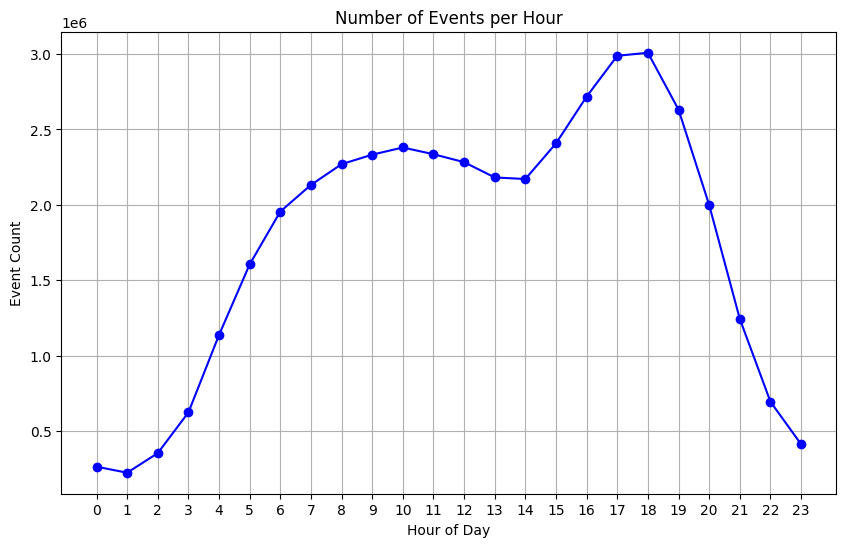

Wall time: 4.853 s
RSS Δ: +27.36 MB
Peak memory Δ: +29.62 MB (OS-dependent)


<ExecutionResult object at 717fdbe17580, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fdbe175e0, raw_cell="# codecell_36c (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [36]:
%%timemem
# codecell_36c (keep this id for tracking purposes)

import matplotlib.pyplot as plt

events_by_hour_pdf = events_by_hour_df.toPandas()

# TODO: Write your code below, but do not remove any lines already in this cell.

plt.figure(figsize=(10, 6))
plt.plot(events_by_hour_pdf['hour'], events_by_hour_pdf['count'], marker='o', color='b')
plt.title('Number of Events per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Event Count')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

In [37]:
%%timemem
# codecell_37a (keep this id for tracking purposes)

# Write your SQL below

sql_query = """
SELECT b.brand_code, CAST(AVG(e.price) AS DECIMAL(10,2)) as avg_price
FROM events e
JOIN brands b ON e.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
GROUP BY b.brand_code
HAVING AVG(e.price) > 10000
ORDER BY avg_price DESC
"""

results = spark.sql(sql_query)

results.show()

[Stage 83:==================================================>     (19 + 2) / 21]

+----------+---------+
|brand_code|avg_price|
+----------+---------+
|      adam| 58946.00|
|      kona| 43759.00|
|  yuandong| 35329.00|
|   bentley| 23164.00|
|      otex| 18633.14|
|    suunto| 10732.82|
|     stark| 10400.25|
+----------+---------+

Wall time: 4.513 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fdbe17be0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fdbe16710, raw_cell="# codecell_37a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [38]:
%%timemem
# codecell_37b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

avg_price_by_brand_df = events_df.filter(F.col("event_type") == "purchase") \
    .join(brands_df, "brand_key") \
    .groupBy("brand_code") \
    .agg(F.avg("price").alias("avg_price")) \
    .filter(F.col("avg_price") > 10000) \
    .withColumn("avg_price", F.round("avg_price", 2)) \
    .orderBy(F.col("avg_price").desc())


avg_price_by_brand_df.show()

[Stage 87:==================================================>     (19 + 2) / 21]

+----------+---------+
|brand_code|avg_price|
+----------+---------+
|      adam|  58946.0|
|      kona|  43759.0|
|  yuandong|  35329.0|
|   bentley|  23164.0|
|      otex| 18633.14|
|    suunto| 10732.82|
|     stark| 10400.25|
+----------+---------+

Wall time: 3.804 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fd08f7fd0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe036cd30, raw_cell="# codecell_37b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

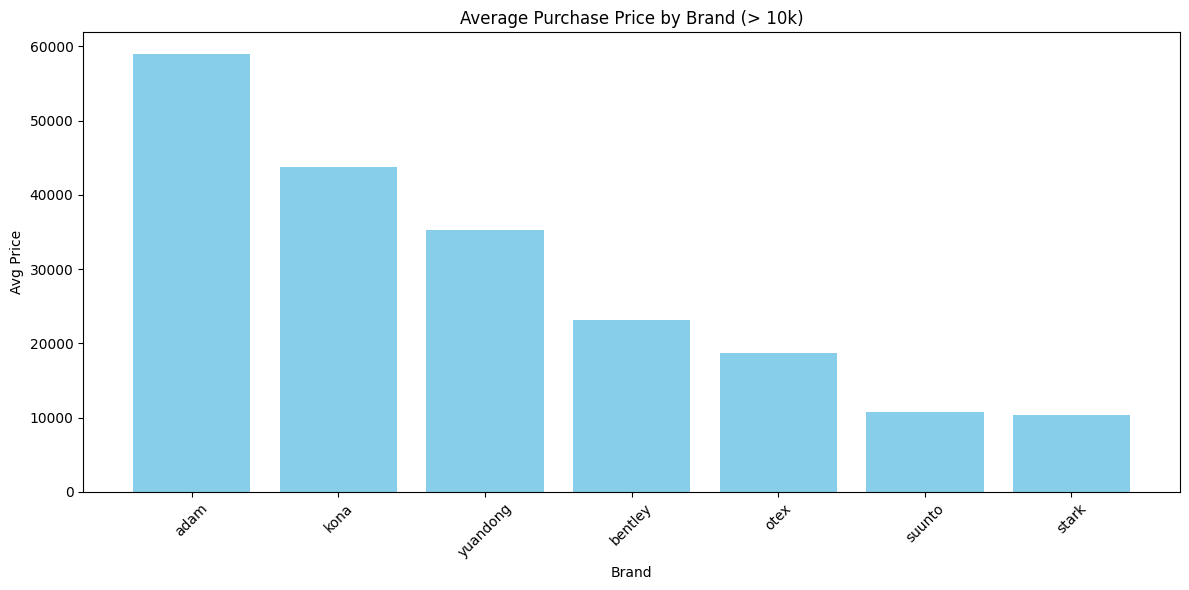

Wall time: 3.667 s
RSS Δ: +3.80 MB
Peak memory Δ: +4.23 MB (OS-dependent)


<ExecutionResult object at 717fd08f7f70, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fd08f7f40, raw_cell="# codecell_37c (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [39]:
%%timemem
# codecell_37c (keep this id for tracking purposes)

import matplotlib.pyplot as plt

avg_price_by_brand_pdf = avg_price_by_brand_df.toPandas()

# TODO: Write your code below, but do not remove any lines already in this cell.

plt.figure(figsize=(12, 6))
plt.bar(avg_price_by_brand_pdf['brand_code'], avg_price_by_brand_pdf['avg_price'], color='skyblue')
plt.title('Average Purchase Price by Brand (> 10k)')
plt.xlabel('Brand')
plt.ylabel('Avg Price')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [40]:
# Get RDDs directly from DataFrames (with required repartitions)
# type: RDD[Row]
events_rdd   = events_df.rdd.repartition(1000)
products_rdd = products_df.rdd.repartition(100)
brands_rdd   = brands_df.rdd.repartition(100)

In [41]:
from pyspark.sql import Row

In [42]:
filtered_events_df = (
    events_df
        .filter((F.col("event_type") == "purchase") & F.col("price").isNotNull())
        .join(brands_df, on="brand_key")
)

filtered_events_df.count()

print(f"Number of rows in events          table: {events_df.count()}")
print(f"Number of rows in filtered events table: {filtered_events_df.count()}")

filtered_events_rdd = filtered_events_df.rdd

Number of rows in events          table: 42351862


Number of rows in filtered events table: 664885


In [43]:
%%timemem
# codecell_5x1 (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

mapped_rdd_v1 = filtered_events_rdd.map(lambda row: (row['brand_code'], float(row['price'])))

grouped_rdd = mapped_rdd_v1.groupByKey()

average_revenue_per_brand_v1 = grouped_rdd \
    .mapValues(lambda prices: list(prices)) \
    .mapValues(lambda prices_list: round(sum(prices_list) / len(prices_list), 2)) \
    .sortBy(lambda x: x[1], ascending=False)

average_revenue_per_brand_v1.take(10)

[('adam', 58946.0),
 ('kona', 43759.0),
 ('yuandong', 35329.0),
 ('bentley', 23164.0),
 ('otex', 18633.13),
 ('suunto', 10732.82),
 ('stark', 10400.25),
 ('zenmart', 9447.0),
 ('baltekstil', 8504.19),
 ('bugati', 8288.42)]

Wall time: 15.160 s
RSS Δ: +0.38 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fd0890850, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fd08906d0, raw_cell="# codecell_5x1 (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=[('adam', 58946.0), ('kona', 43759.0), ('yuandong', 35329.0), ('bentley', 23164.0), ('otex', 18633.13), ('suunto', 10732.82), ('stark', 10400.25), ('zenmart', 9447.0), ('baltekstil', 8504.19), ('bugati', 8288.42)]>

In [44]:
%%timemem
# codecell_5x2 (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.


mapped_rdd_v3 = filtered_events_rdd.map(lambda row: (row['brand_code'], (float(row['price']), 1)))


reduced_rdd = mapped_rdd_v3.reduceByKey(lambda acc, val: (acc[0] + val[0], acc[1] + val[1]))


average_revenue_per_brand_v3 = reduced_rdd \
    .mapValues(lambda x: round(x[0] / x[1], 2)) \
    .sortBy(lambda x: x[1], ascending=False)

average_revenue_per_brand_v3.take(10)

[('adam', 58946.0),
 ('kona', 43759.0),
 ('yuandong', 35329.0),
 ('bentley', 23164.0),
 ('otex', 18633.13),
 ('suunto', 10732.82),
 ('stark', 10400.25),
 ('zenmart', 9447.0),
 ('baltekstil', 8504.19),
 ('bugati', 8288.42)]

Wall time: 10.610 s
RSS Δ: +0.12 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fd03be290, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe0255bd0, raw_cell="# codecell_5x2 (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=[('adam', 58946.0), ('kona', 43759.0), ('yuandong', 35329.0), ('bentley', 23164.0), ('otex', 18633.13), ('suunto', 10732.82), ('stark', 10400.25), ('zenmart', 9447.0), ('baltekstil', 8504.19), ('bugati', 8288.42)]>

In [45]:
spark.sql("""

SELECT * FROM brands b
JOIN products p ON p.brand_key = b.brand_key
WHERE b.brand_key = '423'

""").show()

+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|brand_code|product_id|product_name|        product_desc|brand_key|category_key|product_key|
+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics| blaupunkt|   1802099|    video.tv|The video.tv is a...|      423|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics| blaupunkt|   1802107|    video.tv|The video.tv is a...|      423|           8|       4821|
+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+



In [46]:
# codecell_61a (keep this id for tracking purposes)

from pyspark.sql import Row

def shuffle_join(R, S, keyR, keyS):
    """
    Implémente un 'Shuffle Join' (Reduce-side join) manuel sans utiliser .join().
    """
    

    r_tagged = R.map(lambda row: (row[keyR], ('R', row)))
    s_tagged = S.map(lambda row: (row[keyS], ('S', row)))
    

    all_grouped = r_tagged.union(s_tagged).groupByKey()
    

    def join_reducer(pair):
        key, values = pair
        
        list_r = []
        list_s = []
        
        for source, row in values:
            if source == 'R':
                list_r.append(row)
            elif source == 'S':
                list_s.append(row)
        
        results = []
        
        if list_r and list_s:
            for row_r in list_r:
                d_r = row_r.asDict()
                
                for row_s in list_s:
                    d_s = row_s.asDict()
                    

                    if keyS in d_s:
                        del d_s[keyS]
                    

                    merged_dict = d_r.copy()
                    merged_dict.update(d_s)
                    
                    results.append(Row(**merged_dict))
                    
        return results


    return all_grouped.flatMap(join_reducer)

In [47]:
%%timemem

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key")
shuffle_join_rdd.count()

115584

Wall time: 25.881 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fe02eb460, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fe02e80a0, raw_cell="
shuffle_join_rdd = shuffle_join(brands_rdd, produ.." store_history=False silent=False shell_futures=True cell_id=None> result=115584>

In [48]:
shuffle_join_results_rdd = shuffle_join_rdd.filter(lambda row: row["brand_key"] == 423)
shuffle_join_results_rdd.count()

2

In [49]:
df = spark.createDataFrame(shuffle_join_results_rdd.collect())
df.show()

+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|product_id|product_name|        product_desc|category_key|product_key|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802099|    video.tv|The video.tv is a...|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802107|    video.tv|The video.tv is a...|           8|       4821|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+



In [50]:
# codecell_62a (keep this id for tracking purposes)

from pyspark.sql import Row

def replicated_hash_join(R, S, keyR, keyS):
    """
    Exécute un 'replicated hash join' (broadcast join) manuel.
    R: Le 'petit' RDD qui sera collecté et diffusé.
    S: Le 'grand' RDD qui sera parcouru en parallèle.
    keyR, keyS: Les noms des colonnes de jointure (string).
    """
    
    r_local = R.collect()
    
    hash_map = {}
    for row in r_local:
        k = row[keyR]
        if k not in hash_map:
            hash_map[k] = []
        hash_map[k].append(row)
        
    bc_hash_map = spark.sparkContext.broadcast(hash_map)
    
    def join_mapper(row_s):
        local_map = bc_hash_map.value
        k = row_s[keyS]
        
        results = []
        
        if k in local_map:
            for row_r in local_map[k]:
                d_r = row_r.asDict()
                d_s = row_s.asDict()
                
                if keyS in d_s:
                    del d_s[keyS]
                
                merged_dict = d_r.copy()
                merged_dict.update(d_s)
                
                results.append(Row(**merged_dict))
                
        return results

    return S.flatMap(join_mapper)

In [51]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key")
replicated_hash_join_rdd.count()

115584

Wall time: 3.748 s
RSS Δ: +1.73 MB
Peak memory Δ: +2.18 MB (OS-dependent)


<ExecutionResult object at 717fd03bdbd0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fd03be2f0, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(b.." store_history=False silent=False shell_futures=True cell_id=None> result=115584>

In [52]:
replicated_hash_join_results_rdd = replicated_hash_join_rdd.filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_results_rdd.count()

2

In [53]:
df = spark.createDataFrame(replicated_hash_join_results_rdd.collect())
df.show()

+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|product_id|product_name|        product_desc|category_key|product_key|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802099|    video.tv|The video.tv is a...|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics|   1802107|    video.tv|The video.tv is a...|           8|       4821|
+----------+--------------------+---------+-------------+----------+------------+--------------------+------------+-----------+



In [54]:
%%timemem

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
shuffle_join_rdd.count()

2

Wall time: 21.160 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fd07c4070, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fd07c4040, raw_cell="
shuffle_join_rdd = shuffle_join(brands_rdd, produ.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

In [55]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_rdd.count()

2

Wall time: 2.913 s
RSS Δ: +0.12 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 717fd07c6e90, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fd07c6380, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(b.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

In [56]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(products_rdd, brands_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_rdd.count()

2

Wall time: 9.323 s
RSS Δ: +136.38 MB
Peak memory Δ: +196.68 MB (OS-dependent)


<ExecutionResult object at 717fd080e350, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 717fd080df60, raw_cell="
replicated_hash_join_rdd = replicated_hash_join(p.." store_history=False silent=False shell_futures=True cell_id=None> result=2>

// qcell_7x1290 (keep this id for tracking purposes)

**What are the running times of J1, J2, and J3**?
(You might want to run the cells a few times and take the average.)

- **Running time of J1:** <font color="red">21.1</font> seconds
- **Running time of J2:** <font color="red">2.9</font> seconds
- **Running time of J3:** <font color="red">9.3</font> seconds

**Explain:**

+ If the running times are what you expect, explain why X > Y > Z.
+ If the running times are _not_ what you expect, explain what they _should_ be, and then explain why X > Y > Z.
+ Specifically compare J2 and J3.

**Your answer?**


Analyse des temps d'exécution (J1, J2, J3)

Les temps obtenus (21.1s > 9.3s > 2.9s) sont tout à fait logiques et respectent la hiérarchie attendue : J1 > J3 > J2.

Voici pourquoi, expliqué simplement :

    J1 (21.1s) – Le Shuffle Join : C'est le plus lent. Pour joindre les données, Spark doit déplacer et mélanger des quantités massives d'informations à travers tout le réseau  pour aligner les clés. C'est lourd, coûteux en I/O (lecture/écriture) et ça prend du temps.

    J3 (9.3s) – Le RDD Replicated Join : Il est bien plus rapide que J1 car il utilise une stratégie intelligente : au lieu de tout mélanger, il broadcast la petite table sur chaque nœud. On évite ainsi le gros trafic réseau du Shuffle. Cependant, comme c'est codé "à la main", il souffre de lourdeurs techniques ( qui le ralentissent par rapport à une solution native.

    J2 (2.9s) – Le Native Broadcast Join : C'est le grand gagnant. Il utilise la même stratégie intelligente que J3, MAIS il profite de toute la puissance du moteur interne de Spark . Tout est optimisé en binaire et géré directement par le moteur, sans les ralentissements liés au code manuel Python.

Comparaison Spécifique : J2 vs J3

C'est le match Moteur Optimisé (J2) contre Code Manuel (J3).

    Point commun : Les deux utilisent la même stratégie algorithmique (le Broadcast). Ils gagnent tous les deux du temps en évitant de déplacer la grosse table (pas de Shuffle).

    Différence :

        J2 est exécuté par le moteur natif de Spark (en C++/Java optimisé). Il est ultra-efficace.

        J3 implique de faire passer les données par Python (sérialisation/désérialisation), ce qui ajoute une "taxe" de performance importante. C'est pour cela que J3 est environ 3 fois plus lent que J2, même s'ils font logiquement la même chose.

LAB 3 practice

In [59]:
from pyspark.sql import SparkSession, functions as F, types as T
spark = SparkSession.builder.appName("de1-lab3").getOrCreate()

clicks_schema = T.StructType([
    T.StructField("prev_title", T.StringType(), True),
    T.StructField("curr_title", T.StringType(), True),
    T.StructField("type", T.StringType(), True),
    T.StructField("n", T.IntegerType(), True),
    T.StructField("ts", T.TimestampType(), True),
])
dim_schema = T.StructType([
    T.StructField("curr_title", T.StringType(), True),
    T.StructField("curr_category", T.StringType(), True),
])


In [60]:
base = "data/"
paths = [f"{base}lab3_clicks_2025-05.csv", f"{base}lab3_clicks_2025-06.csv", f"{base}lab3_clicks_2025-07.csv"]
row_df = (spark.read.schema(clicks_schema).option("header","true").csv(paths)
            .withColumn("year", F.year("ts")).withColumn("month", F.month("ts")))
row_df.cache()
print("Rows:", row_df.count())
row_df.printSchema()
row_df.show(5, truncate=False)


Rows: 15000
root
 |-- prev_title: string (nullable = true)
 |-- curr_title: string (nullable = true)
 |-- type: string (nullable = true)
 |-- n: integer (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

+-----------------------------+--------------+----+---+-------------------+----+-----+
|prev_title                   |curr_title    |type|n  |ts                 |year|month|
+-----------------------------+--------------+----+---+-------------------+----+-----+
|ETL                          |PySpark       |link|431|2025-06-01 02:57:00|2025|6    |
|Data_engineering             |Broadcast_join|link|347|2025-06-15 13:40:00|2025|6    |
|Python_(programming_language)|MapReduce     |link|39 |2025-06-07 15:14:00|2025|6    |
|ETL                          |Data_warehouse|link|401|2025-06-07 04:59:00|2025|6    |
|Python_(programming_language)|Dataframe     |link|155|2025-06-06 06:40:00|2025|6    |
+-------------------

In [61]:
# Query Q1: top transitions per month for 'link'
q1_row = (row_df.filter(F.col("type")=="link")
           .groupBy("year","month","prev_title","curr_title")
           .agg(F.sum("n").alias("n"))
           .orderBy(F.desc("n"))
           .limit(50))
q1_row.explain("formatted")

import pathlib, datetime as _dt
pathlib.Path("proof").mkdir(exist_ok=True)
with open("proof/plan_row.txt","w") as f:
    f.write(str(_dt.datetime.now())+"\n")
    f.write(q1_row._jdf.queryExecution().executedPlan().toString())
print("Saved proof/plan_row.txt")


== Physical Plan ==
AdaptiveSparkPlan (11)
+- TakeOrderedAndProject (10)
   +- HashAggregate (9)
      +- Exchange (8)
         +- HashAggregate (7)
            +- Project (6)
               +- Filter (5)
                  +- InMemoryTableScan (1)
                        +- InMemoryRelation (2)
                              +- * Project (4)
                                 +- Scan csv  (3)


(1) InMemoryTableScan
Output [6]: [curr_title#689, month#695, n#691, prev_title#688, type#690, year#694]
Arguments: [curr_title#689, month#695, n#691, prev_title#688, type#690, year#694], [isnotnull(type#690), (type#690 = link)]

(2) InMemoryRelation
Arguments: [prev_title#688, curr_title#689, type#690, n#691, ts#692, year#694, month#695], StorageLevel(disk, memory, deserialized, 1 replicas)

(3) Scan csv 
Output [5]: [prev_title#688, curr_title#689, type#690, n#691, ts#692]
Batched: false
Location: InMemoryFileIndex [file:/home/qdomon/data/lab3_clicks_2025-05.csv, ... 2 entries]
ReadSchema: struct

In [64]:
col_base = "outputs/lab3/columnar"
# Write columnar
(row_df
 .write.mode("overwrite")
 .partitionBy("year","month")
 .parquet(f"{col_base}/clicks_parquet"))

# Re‑read columnar for fair comparison
col_df = spark.read.schema(clicks_schema.add("year", "integer").add("month", "integer")).parquet(f"{col_base}/clicks_parquet")
col_df.cache()
print("Columnar rows:", col_df.count())


Columnar rows: 15000


In [65]:
q1_col = (col_df.filter(F.col("type")=="link")
           .groupBy("year","month","prev_title","curr_title")
           .agg(F.sum("n").alias("n"))
           .orderBy(F.desc("n"))
           .limit(50))
q1_col.explain("formatted")
with open("proof/plan_column.txt","w") as f:
    from datetime import datetime as _dt
    f.write(str(_dt.now())+"\n")
    f.write(q1_col._jdf.queryExecution().executedPlan().toString())
print("Saved proof/plan_column.txt")


== Physical Plan ==
AdaptiveSparkPlan (11)
+- TakeOrderedAndProject (10)
   +- HashAggregate (9)
      +- Exchange (8)
         +- HashAggregate (7)
            +- Project (6)
               +- Filter (5)
                  +- InMemoryTableScan (1)
                        +- InMemoryRelation (2)
                              +- * ColumnarToRow (4)
                                 +- Scan parquet  (3)


(1) InMemoryTableScan
Output [6]: [curr_title#1621, month#1626, n#1623, prev_title#1620, type#1622, year#1625]
Arguments: [curr_title#1621, month#1626, n#1623, prev_title#1620, type#1622, year#1625], [isnotnull(type#1622), (type#1622 = link)]

(2) InMemoryRelation
Arguments: [prev_title#1620, curr_title#1621, type#1622, n#1623, ts#1624, year#1625, month#1626], StorageLevel(disk, memory, deserialized, 1 replicas)

(3) Scan parquet 
Output [7]: [prev_title#1620, curr_title#1621, type#1622, n#1623, ts#1624, year#1625, month#1626]
Batched: true
Location: InMemoryFileIndex [file:/home/qdomon/o

In [66]:
dim = spark.read.schema(dim_schema).option("header","true").csv("data/lab3_dim_curr_category.csv")
# Non‑broadcast join
j1 = (col_df.join(dim, "curr_title", "left")
      .groupBy("curr_category")
      .agg(F.sum("n").alias("total_n"))
      .orderBy(F.desc("total_n")))
j1.explain("formatted")

# Broadcast join
from pyspark.sql.functions import broadcast
j2 = (col_df.join(broadcast(dim), "curr_title", "left")
      .groupBy("curr_category")
      .agg(F.sum("n").alias("total_n"))
      .orderBy(F.desc("total_n")))
j2.explain("formatted")

# Save one plan for evidence
with open("proof/plan_broadcast.txt","w") as f:
    from datetime import datetime as _dt
    f.write(str(_dt.now())+"\n")
    f.write(j2._jdf.queryExecution().executedPlan().toString())
print("Saved proof/plan_broadcast.txt")


== Physical Plan ==
AdaptiveSparkPlan (15)
+- Sort (14)
   +- Exchange (13)
      +- HashAggregate (12)
         +- Exchange (11)
            +- HashAggregate (10)
               +- Project (9)
                  +- BroadcastHashJoin LeftOuter BuildRight (8)
                     :- InMemoryTableScan (1)
                     :     +- InMemoryRelation (2)
                     :           +- * ColumnarToRow (4)
                     :              +- Scan parquet  (3)
                     +- BroadcastExchange (7)
                        +- Filter (6)
                           +- Scan csv  (5)


(1) InMemoryTableScan
Output [2]: [curr_title#1621, n#1623]
Arguments: [curr_title#1621, n#1623]

(2) InMemoryRelation
Arguments: [prev_title#1620, curr_title#1621, type#1622, n#1623, ts#1624, year#1625, month#1626], StorageLevel(disk, memory, deserialized, 1 replicas)

(3) Scan parquet 
Output [7]: [prev_title#1620, curr_title#1621, type#1622, n#1623, ts#1624, year#1625, month#1626]
Batched: true
L

In [67]:
# Q2: daily GMV‑like metric (sum of n) for a specific title window
q2_row = (row_df.filter((F.col("type")=="link") & F.col("curr_title").isin("Apache_Spark","PySpark"))
           .groupBy("year","month","curr_title").agg(F.sum("n").alias("n")).orderBy("year","month","curr_title"))
q2_col = (col_df.filter((F.col("type")=="link") & F.col("curr_title").isin("Apache_Spark","PySpark"))
           .groupBy("year","month","curr_title").agg(F.sum("n").alias("n")).orderBy("year","month","curr_title"))

# Trigger
_ = q2_row.count(); _ = q2_col.count()

# Q3: heavy cardinality grouping
q3_row = row_df.groupBy("prev_title","curr_title").agg(F.sum("n").alias("n")).orderBy(F.desc("n")).limit(100)
q3_col = col_df.groupBy("prev_title","curr_title").agg(F.sum("n").alias("n")).orderBy(F.desc("n")).limit(100)
_ = q3_row.count(); _ = q3_col.count()

print("Open Spark UI at http://localhost:4040 while each job runs and record metrics into lab3_metrics_log.csv")


Open Spark UI at http://localhost:4040 while each job runs and record metrics into lab3_metrics_log.csv


### Lab projet-final


In [7]:
import yaml, pathlib, datetime
from pyspark.sql import SparkSession, functions as F, types as T

with open("/home/qdomon/outputs/project/de1_project_config.yml") as f:
    CFG = yaml.safe_load(f)

spark = SparkSession.builder.appName("de1-project").getOrCreate()
CFG


{'database': {'host': 'localhost',
  'port': 5432,
  'name': 'esiee_full',
  'user': 'esiee_reader',
  'password': 'azerty123',
  'schema': 'retail'},
 'paths': {'raw_csv_glob': '/mnt/d/E4/Data_engineering/*.csv',
  'bronze': '/home/qdomon/outputs/project/bronze',
  'silver': '/home/qdomon/outputs/project/silver',
  'proof': '/home/qdomon/outputs/project/proof',
  'gold': '/home/qdomon/outputs/project/gold'},
 'spark': {'app_name': 'De1Project',
  'master': 'local[*]',
  'shuffle_partitions': 400}}

In [8]:
from pathlib import Path

raw_glob = CFG["paths"]["raw_csv_glob"]
bronze = CFG["paths"]["bronze"]
proof = CFG["paths"]["proof"]

# Read only events.csv to avoid schema mismatch with other CSV files
raw_dir = str(Path(raw_glob).parent)  # Extract directory from glob pattern
events_path = f"{raw_dir}/events.csv"
df_raw = (spark.read.option("header","true").csv(events_path))
df_raw.write.mode("overwrite").csv(bronze)  # keep raw as CSV copy
print("Bronze written:", bronze)


[Stage 13:=====================================================>  (25 + 1) / 26]

Bronze written: /home/qdomon/outputs/project/bronze


In [9]:
silver = CFG["paths"]["silver"]

# Read only events.csv which has session_id and price columns
from pathlib import Path
raw_glob = CFG["paths"]["raw_csv_glob"]
raw_dir = str(Path(raw_glob).parent)  # Extract directory from glob pattern
events_path = f"{raw_dir}/events.csv"

# Example typing; adapt to dataset
from pyspark.sql import functions as F, types as T
df_raw = (spark.read.option("header","true").csv(events_path))

df_silver = (df_raw
    .withColumn("price", F.when(
        F.col("price").rlike("^-?[0-9]+(\\.[0-9]+)?$"), 
        F.col("price").cast("double")
    ))
    .filter(F.col("price").isNotNull()))

df_silver.write.mode("overwrite").parquet(silver)
print("Silver written:", silver)

[Stage 15:=====================================================>  (25 + 1) / 26]

Silver written: /home/qdomon/outputs/project/silver


In [10]:
gold = CFG["paths"]["gold"]

# Example gold Q1 - consistent with silver column names
# DO NOT partition by session_id as it has millions of unique values!
# Instead, write without partitioning or partition by a low-cardinality column
gold_q1 = (df_silver.groupBy("session_id").agg(F.sum("price").alias("sum_price")))
(gold_q1.write.mode("overwrite").parquet(f"{gold}/q1_daily"))

print("Gold written:", gold)

[Stage 18:=================================================>        (6 + 1) / 7]

Gold written: /home/qdomon/outputs/project/gold


In [13]:
import os, datetime as _dt, pathlib
pathlib.Path(proof).mkdir(parents=True, exist_ok=True)

# Add date column from event_time for partitioning
df_silver_with_date = df_silver.withColumn("date", F.to_date("event_time"))

# Example baseline plan
plan = gold_q1._jdf.queryExecution().executedPlan().toString()
with open(f"{proof}/baseline_q1_plan.txt","w") as f:
    f.write(str(_dt.datetime.now())+"\n")
    f.write(plan)
print("Saved baseline plan. Record Spark UI metrics now.")


Saved baseline plan. Record Spark UI metrics now.


In [14]:
# Example: narrow projection and pre‑aggregation before write (use date and price columns)
df_silver_min = df_silver_with_date.select("date","price")
gold_q1_opt = (df_silver_min.groupBy("date").agg(F.sum("price").alias("sum_price")))
# Use coalesce to avoid millions of small partitions
gold_q1_opt.coalesce(50).write.mode("overwrite").parquet(f"{gold}/q1_daily_opt")

plan_opt = gold_q1_opt._jdf.queryExecution().executedPlan().toString()
with open(f"{proof}/optimized_q1_plan.txt","w") as f:
    f.write(str(_dt.datetime.now())+"\n")
    f.write(plan_opt)
print("Saved optimized plan. Record Spark UI metrics now.")


[Stage 19:=====================================================>  (25 + 1) / 26]

Saved optimized plan. Record Spark UI metrics now.


In [15]:
spark.stop()
print("Spark session stopped.")


Spark session stopped.
